# Imports and utility functions

In [0]:
import sys
import glob
import os
import warnings
import math
import pandas as pd

import itertools
from collections import namedtuple

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
import scipy.io as sio
import scipy.stats

import sklearn
from sklearn import linear_model
import statsmodels.api as sm

from colabtools import adhoc_import
from colabtools import fileedit
from matplotlib.colors import ListedColormap

import scipy.optimize
import functools
import warnings
warnings.simplefilter('ignore')


In [0]:
data_types = [namedtuple('Cell', ['animal', 'date', 'events', 'responses', 'area', "analyzedData", "rabiesDate", "TimeAlign",
                                  "CluSep", "valueAnalyzed", "latency", "RecordDate", 'psth', 'timeWindow', "checkLaser", "lightResult"]),
              namedtuple("events", ['odorOn', 'odorOff', 'odorID', 'laserOn', 'laserOff', 'rewardOn', 'airpuffOn', 
                                    'leverOn', 'firstLick', 'trialType', 'freeRewardOn', 'freeAirpuffOn', 'freeLaserOn', 
                                    'freeLaserOff', 'freeRewardOutSession', 'freeAirpuffOutSession', 'trialStart',
                                    'laser_sequence', 'laser_Hz1']),
              namedtuple("responses", ('spike', 'lick', 'lever', 'laserEvokedSpikes', 'LaserLatency', 'laserEvokedSpikesLatency',
                                       'meanLaserWaveform', 'stderrLaserWaveform', 'meanNoLaserWaveform', 'stderrNoLaserWaveform')),
              namedtuple("TimeAlign", ["DelayValue", "TimeShift"]),
              namedtuple("checkLaser", ['Raw_Spon_wv', 'Raw_wv', 'Raw_Spon_wv_Nofilter', 'Raw_wv_Nofilter', 'responsesProb',
                                        'LaserEvokedPeak', 'p_salt', 'p_inhibit']),
              namedtuple("analyzedData", ['smoothPSTH', 'rawPSTH', 'rocPSTH', 'raster', 'psthName', 'rawLick', 'rasterLick', 'psth']),
              namedtuple('lightResult', ['lowSaltP', 'highSaltP', 'wvCorrAll', 'wvCorrSpecific', 'latency'])
             ]

data_types = dict([(dtype.__name__, dtype) for dtype in data_types])


def make_file(fname, fig, format='pdf'):
  fname = '/tmp/' + fname
  with open(fname, 'w') as f:
    fig.savefig(f, facecolor='none', edgecolor='none', format=format)
  fileedit.download_file(fname)


def load_data(filename, debug=False):
  if debug:
    print(filename)
  data = sio.loadmat(filename)

  kwargs = {'analyzedData': None,
            'animal': filename.split("/")[-1].split("_")[0],
            'date': filename.split("/")[-1].split("_")[1]}

  for key in data:
    if key.startswith("__") or key == "header":
      continue
    
    args = {}
    if key in ["None",]:
      continue

    if key not in data_types:
      kwargs[key] = data[key]
      continue

    for field in data_types[key]._fields:
      args[field] = None
    
    for name in data[key].dtype.names:
      args[name] = data[key][name][0,0]

    kwargs[key] = data_types[key](**args)
  
  for key in data_types['Cell']._fields:
    if key not in kwargs:
      kwargs[key] = None

  return data_types['Cell'](**kwargs)

def load_task(filepath, prefix="", debug=False):
  names = [fname for fname in os.listdir(filepath) if fname.startswith(prefix) and fname.endswith('.mat')]
  cells = [load_data(os.path.join(filepath, fname), debug=debug) for fname in names]
  print("Loaded %d cell recordings..." % len(cells))
  return cells

def load_disjoint_task(filepath, exclude, prefix="", debug=False):
  exclude_cells = [fname for fname in os.listdir(exclude) if fname.startswith(prefix) and fname.endswith('.mat')]
  names = [fname for fname in os.listdir(filepath) if fname.startswith(prefix) and fname.endswith('.mat')]
  cells = [load_data(os.path.join(filepath, fname), debug=debug) for fname in names if fname not in exclude_cells]
  print("Loaded %d cell recordings..." % len(cells))
  return cells


In [0]:
def times_to_indices(times, start_end, resolution):
  """Given a time window sampled at resolution,
  converts the range to a list of indices in that time window.
  """
  return np.arange((times[0] - start_end[0])/resolution,
                   (times[1] - start_end[0])/resolution, dtype=np.int32)


def compute_firing_rate(task,
                        psth_window = (-1000, 3000),           # In units of ms
                        psth_resolution = 1,                   # In units of ms
                        baseline_window = (-1000, 0),          # In units of ms
                        smoothing_kernel = np.ones(100)/100.): # Box-filter
  peri_events = []
  rasters = [[] for _ in range(len(task))]

  for cellid in range(len(task)):
    datum = task[cellid]
    cell_tasks = {}
    
    # Task types observed by this cell
    task_types = set(task[cellid].events.trialType.ravel())
    task_types = sorted([int(v) for v in task_types if not np.isnan(v)])
    
    for type_id in task_types:
      type_ind = np.where(datum.events.trialType == type_id)
      odor_id = datum.events.odorID[type_ind]

      # Units of these times are in milliseconds
      odor_on_times = datum.events.odorOn[type_ind]
      odor_off_times = datum.events.odorOff[type_ind]
      reward_on_times = datum.events.rewardOn[type_ind]

      if datum.events.trialStart is not None:
        # First try to use trialStart (regardless of Cued or Free)
        starts = datum.events.trialStart[type_ind]
      else:
        # Fall back to odor on times
        starts = odor_on_times

      PSTC = np.zeros((len(starts), psth_window[1] - psth_window[0]))
      psth = []
      
      # For each trial, 
      for trial in range(len(starts)):
        # Take a window around the trial start or odor on times
        window_start = starts[trial] + psth_window[0]
        window_end = starts[trial] + psth_window[1]
        spike_window = np.where((datum.responses.spike < window_end) & (datum.responses.spike >= window_start))

        # Find spikes that happen in that window, and map times to PSTH indices
        spike_times = datum.responses.spike[spike_window]
        spike_psth_indices = np.floor((spike_times - starts[trial]) / psth_resolution) - psth_window[0] / psth_resolution

        # Increment the PSTH with these spikes
        for spike_index in spike_psth_indices:
          PSTC[trial, int(spike_index)] += 1

        # Convert spikes/10ms to spikes/s
        PSTH = (1000 / psth_resolution) * PSTC[trial]
        baselines = np.nanmean(PSTH[times_to_indices(baseline_window, psth_window, psth_resolution)])
        PSTH -= baselines
        PSTH = np.convolve(PSTH, smoothing_kernel, mode='same')
        psth.append(PSTH)
      
      cell_tasks[type_id-1] = np.array(psth)
    peri_events.append(cell_tasks)
  return peri_events

def collapse_range(data, indices):
  cell_data = []
  for cell in data:
    per_cell = dict((task, cell[task][:, indices].mean(1)) for task in cell)
    cell_data.append(per_cell)
  return cell_data

def select_tasks(data, tasks):
  cell_data = []
  for cell in data:
    per_cell = dict((task, cell[task]) for task in tasks if task in cell)
    if per_cell:
      cell_data.append(per_cell)

  return cell_data

def collapse_trials(data, tasks):
  return np.array([[cell[task].mean(0) for task in tasks] for cell in data])


In [0]:
def load_matlab(filename):
  data = sio.loadmat(filename)
  return data

# Generating Figures

### Style configurations

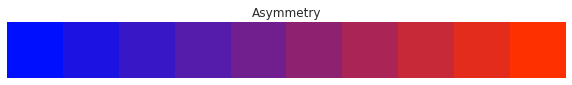

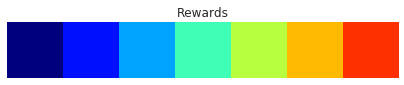

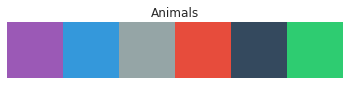

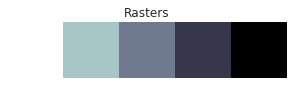

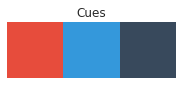

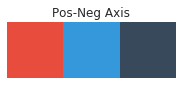

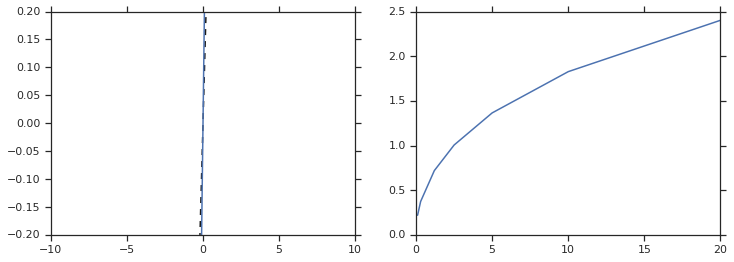

In [0]:
import matplotlib.colors as mcol

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

reward_cmap = plt.cm.jet(np.linspace(0., 1., 8)[:-1])
animal_cmap = sns.color_palette(flatui)
raster_cmap = plt.cm.bone_r

asym_cmap = plt.cm.autumn_r
asym_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",[reward_cmap[1], reward_cmap[-1]])


sns.set_style('white')

sns.palplot(asym_cmap(np.linspace(0., 1., 10)))
plt.gca().axis('off')
_ = plt.title("Asymmetry")

sns.palplot(reward_cmap)
plt.gca().axis('off')
_ = plt.title("Rewards")

sns.palplot(animal_cmap)
plt.gca().axis('off')
_ = plt.title("Animals")

sns.palplot(raster_cmap(np.linspace(0., 1., 5)))
plt.gca().axis('off')
_ = plt.title("Rasters")

cue_cmap = sns.color_palette([flatui[3], flatui[1], "#38495C"])
sns.palplot(cue_cmap)
plt.gca().axis('off')
_ = plt.title("Cues")

pos_neg_cmap = cue_cmap
sns.palplot(cue_cmap)
plt.gca().axis('off')
_ = plt.title("Pos-Neg Axis")

### Utility function model assumptions:
fmax = 10.
sigma = 200
utility_func = lambda r: (fmax * np.sign(r) * np.abs(r)**(.5)) / (np.abs(r)**(.5) + sigma**(.5))
#utility_func = lambda r: r

### Response function model assumption:
# Linear
response_func = lambda r: r

#response_func = lambda r: np.abs(r)**(1./3) * np.sign(r)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
xs = np.linspace(-10., 10., 100)
plt.plot(xs, xs, 'k--')
plt.plot(xs, utility_func(xs))
_ = plt.ylim([-.2, .2])

plt.subplot(1, 2, 2)
juice_amounts = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
plt.plot(juice_amounts, utility_func(juice_amounts))


## Figure2ab


In [0]:
fig2b = load_matlab("Figure2b.mat")
conditions = ['0.1uL','0.3uL','1.2uL','2.5uL','5uL','10uL','20uL']
juice_amounts = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])

In [0]:
def plot_zero_crossings(zero_crossings, responses, smooth=10.):
  fig = plt.figure(figsize=(6, 6))

  ind = list(np.argsort(zero_crossings))
  ind = np.array(ind)
  juice_response = responses[ind]
  xk = np.arange(len(ind))
  xs = np.linspace(0., len(ind)-1., 100)

  for cell in range(len(juice_response)):
    plt.plot([juice_response[cell].min(), juice_response[cell].max()],
             np.ones(2)*cell, linewidth=1, linestyle=':', color='k', zorder=1)

  for reward_ind in range(juice_response.shape[1]):
    plt.scatter(juice_response[:, reward_ind], np.arange(len(juice_response)),
                c=reward_cmap[reward_ind], linewidth=1, edgecolor='w', zorder=4,
                s=50, label=conditions[reward_ind])
    
    # Down weight endpoints for the interpolating spline
    weights = np.ones(len(ind))
    weights[-1] = 0.5
    weights[0] = 0.5

    cs = scipy.interpolate.UnivariateSpline(
        xk, juice_response[:, reward_ind], w=weights)

    cs.set_smoothing_factor(smooth)
    plt.plot(cs(xs), xs, c=reward_cmap[reward_ind], zorder=3,
             linewidth=2, alpha=1.)

  plt.axvline(linestyle='-', color='k', zorder=2, linewidth=2.)
  _ = plt.ylim([-1, len(juice_response)])

  ax = plt.gca()
  ax.yaxis.set_major_locator(plt.NullLocator())
  ax.xaxis.tick_bottom()

  plt.xlabel('$\\Delta$ Firing Rate (variance normalized)', fontsize=18)
  plt.ylabel('Cell (Sorted by zero-crossing)', fontsize=18)


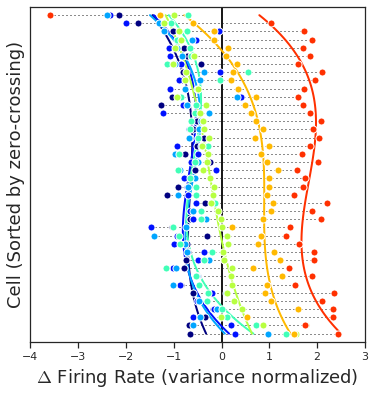

In [0]:
#@title Zero-crossings for all animals

plot_zero_crossings(fig2b['zeroCrossings'].flatten(),
                    np.nanmean(fig2b['dataExpectedNorm'], axis=-1))



### Simulation

In [0]:
num_cells = 151
num_steps = 25000
trials = 10
base_lrate = 0.02

juice_probs = np.array(
    [0.06612594, 0.09090909, 0.14847358, 0.15489467,
     0.31159175, 0.1509519 , 0.07705306])

In [0]:
# Simulate classic TD
values = np.zeros((trials, num_cells))
alpha = np.random.random((trials, num_cells))

for trial in range(trials):
  for step in range(num_steps):
    reward = np.random.choice(juice_amounts, p=juice_probs)
    delta = utility_func(reward) - values[trial]
    values[trial] += alpha[trial] * response_func(delta) * base_lrate

ind = np.argsort(values)
values = np.array([v[i] for v, i in zip(values, ind)])
alpha = np.array([a[i] for a, i in zip(alpha, ind)])

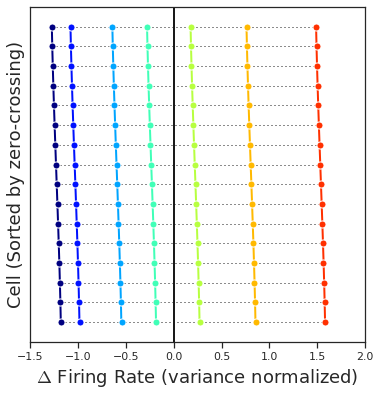

In [0]:
responses = response_func(alpha[:, :, None] * (utility_func(juice_amounts)[None, None] - values[:, :, None]))
ind = np.argsort(values.mean(0))

responses = responses.mean(0)
responses = responses[ind]
responses /= responses.std(1, ddof=1, keepdims=True)

plot_zero_crossings(values.mean(0)[::10], responses[::10])

In [0]:
# Simulate distributional TD
distribution = np.zeros((trials, num_cells))

alpha_pos = np.random.random(size=(trials, num_cells))
alpha_neg = np.random.random(size=(trials, num_cells))
tau = alpha_pos / (alpha_pos + alpha_neg)

for trial in range(trials):
  for step in range(num_steps):
    reward = (np.random.choice(juice_amounts, p=juice_probs))
    delta = utility_func(reward) - distribution[trial]

    valence = np.array(delta <= 0., dtype=np.float32)
    distribution[trial] += (valence * alpha_neg[trial] + (1. - valence) * alpha_pos[trial]) * response_func(delta) * base_lrate

  ind = np.argsort(tau[trial])
  tau[trial] = tau[trial][ind]
  alpha_pos[trial] = alpha_pos[trial][ind]
  alpha_neg[trial] = alpha_neg[trial][ind]
  distribution[trial] = distribution[trial][ind]


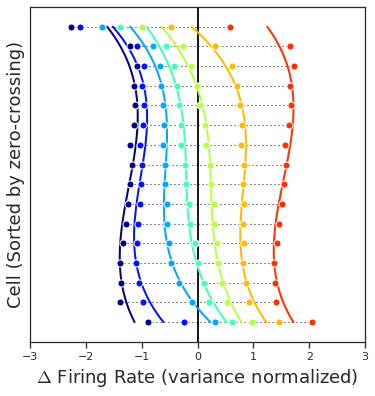

In [0]:
delta = (utility_func(juice_amounts)[None, None] - distribution[:,:,None])
valence = np.array(delta <= 0., dtype=np.float32)
lrfloor = lambda x: 0.2 + x
responses = response_func(delta) * (valence * lrfloor(alpha_neg)[:, :, None] + (1. - valence) * lrfloor(alpha_pos)[:, :, None])
responses = responses.mean(0)
ind = np.argsort(distribution.mean(0))

responses = responses[ind]
responses /= (responses.std(1, ddof=1, keepdims=True))
plot_zero_crossings(distribution.mean(0)[::10], (responses[::10]))


## Figure2d

In [0]:
fig2d = load_matlab("Figure2d.mat")

In [0]:
smooth = False
raster = fig2d['rasterData']
print(raster.shape)
print(fig2d['note'][0])

(16, 7, 60, 425)
we plotted cells 5 and 12, using trialtype5


In [0]:
smooth_raster1 = np.array([trial for trial in raster[4, 4] if not np.isnan(trial[0])])
smooth_raster2 = np.array([trial for trial in raster[11, 4] if not np.isnan(trial[0])])

if smooth:
  fltr = lambda t: (1. - np.exp(-t)) * np.exp(-t / 20.)
  smooth_raster1 = np.array([np.convolve(trial, fltr(np.arange(100))) for trial in raster[4, 4] if not np.isnan(trial[0])])
  smooth_raster2 = np.array([np.convolve(trial, fltr(np.arange(100))) for trial in raster[5, 4] if not np.isnan(trial[0])])

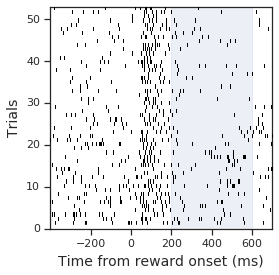

In [0]:
fig = plt.figure()
xvals = np.arange(-500, 1199, 4)
smt = smooth_raster2.copy()
smt[smt == 0.] = np.nan
plt.imshow(smt, cmap=raster_cmap, 
           aspect=1100./smooth_raster2.shape[0], vmin=0., vmax=1.,
           extent=[-500, 1200, 1, smooth_raster2.shape[0]], zorder=5,
           interpolation='nearest')

plt.fill_between([200, 600], 0, smooth_raster2.shape[0], zorder=1, color='b', alpha=0.1)

plt.xlim([-400, 700])
_ = plt.xticks([-200, 0, 200, 400, 600])
plt.ylabel("Trials", fontsize=14)
plt.xlabel("Time from reward onset (ms)", fontsize=14)
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()

plt.tight_layout()

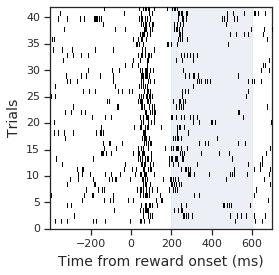

In [0]:
fig = plt.figure()
xvals = np.arange(-500, 1199, 4)
smt = smooth_raster1.copy()
smt[smt == 0.] = np.nan
plt.imshow(smt, cmap=raster_cmap, 
           aspect=1100./smooth_raster1.shape[0], vmin=0., vmax=1.,
           extent=[-500, 1200, 1, smooth_raster1.shape[0]], zorder=5,
           interpolation='nearest')

plt.fill_between([200, 600], 0, smooth_raster1.shape[0], zorder=1, color='b', alpha=0.1)

plt.xlim([-400, 700])
_ = plt.xticks([-200, 0, 200, 400, 600])
plt.ylabel("Trials", fontsize=14)
plt.xlabel("Time from reward onset (ms)", fontsize=14)
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()

plt.tight_layout()


## Figure3

In [0]:
fig3_da_hist = load_matlab("DopamineTHist.mat")
fig3_ga_hist = load_matlab("GABATHist.mat")

fig3_simTD_hist = load_matlab("SimulationClassicalHist.mat")
fig3_simDTD_hist = load_matlab("SimulationDistHist.mat")


In [0]:
fig3_ga_psth = load_matlab("AllPSTHGABA.mat")
fig3_da_psth = load_matlab("AllPSTHDopamine.mat")


### Histograms: Figure 3ab

In [0]:
def plot_hist(data, ax=None):
  centers = data['hcenters'].flatten()
  height = data['ckhist'].flatten()
  width = 1.
  if ax is not None:
    ax.bar(centers - width/2. , height, width=width, color='#3498db', edgecolor='w', linewidth=2)
  
  xs = np.linspace(-13., 13., 2000)
  ax.plot(xs, scipy.stats.t.pdf(xs, 20)/scipy.stats.t.pdf(xs, 30).max(),
          color='k', linewidth=6, alpha=1.)
  ax.set_xlim([-13., 13.])
  ax.set_xlabel("t-Statistic", fontsize=18)
  ax.set_ylabel("Relative frequency", fontsize=18)
  plt.tight_layout()
  

In [0]:
def plot_hist(data, ax=None):
  centers = data['hcenters'].flatten()
  height = data['ckhist'].flatten()
  width = 1.
  if ax is not None:

    ax.bar(centers - width/2. , height, width=width, 
           color=asym_cmap(scipy.stats.norm.cdf(centers, scale=3)),
           edgecolor='w', linewidth=2)
  
  xs = np.linspace(-13., 13., 2000)
  ax.plot(xs, scipy.stats.t.pdf(xs, 20)/scipy.stats.t.pdf(xs, 30).max(),
          color='k', linewidth=6, alpha=1.)
  ax.set_xlim([-13., 13.])
  ax.set_xlabel("t-Statistic", fontsize=18)
  ax.set_ylabel("Relative frequency", fontsize=18)
  plt.tight_layout()
  

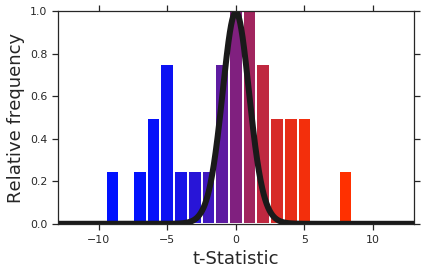

In [0]:
plt.figure(figsize=(6, 4))
plot_hist(fig3_da_hist, ax=plt.subplot(1, 1, 1))

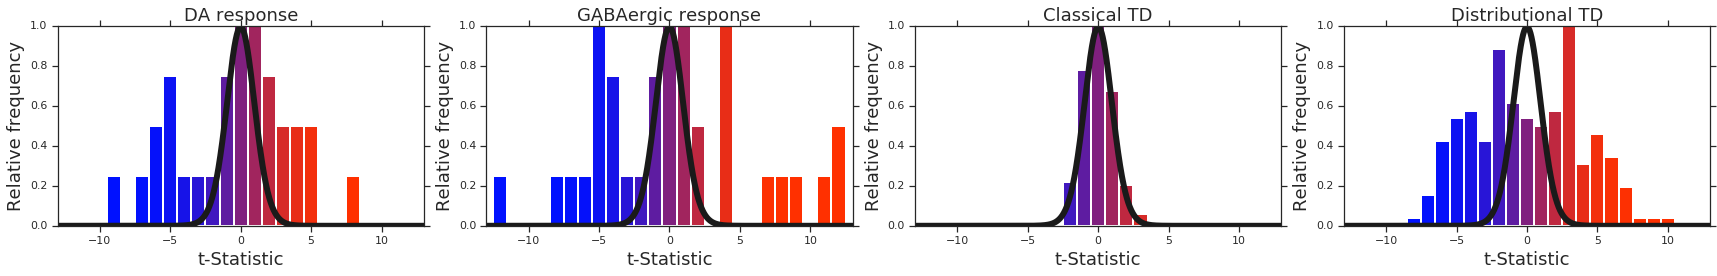

In [0]:
plt.figure(figsize=(6*4, 4))
plot_hist(fig3_da_hist, ax=plt.subplot(1, 4, 1))
plt.title("DA response", fontsize=18)

plot_hist(fig3_ga_hist, ax=plt.subplot(1, 4, 2))
plt.title("GABAergic response", fontsize=18)

plot_hist(fig3_simTD_hist, ax=plt.subplot(1, 4, 3))
plt.title("Classical TD", fontsize=18)

plot_hist(fig3_simDTD_hist, ax=plt.subplot(1, 4, 4))
plt.title("Distributional TD", fontsize=18)


### DA Timecourses: Figure 3c

In [0]:
def plot_varexp_cell(resp, sem, times, cue='reward', window=(0, 200)):
  fig = plt.figure()
  for c in range(3):
    plt.fill_between(times, resp[c] - sem[c], resp[c] + sem[c],
                     alpha=0.2, color=cue_cmap[c], zorder=3)
    plt.plot(times, resp[c], color=cue_cmap[c], zorder=4)

  ylm = plt.ylim()
  plt.fill_between([window[0], window[1]], np.ones(2)*ylm[0], np.ones(2)*ylm[1], color='k', alpha=0.05, zorder=1)
  plt.axvline(0., color='k', linestyle='--', zorder=1)
  
  plt.xlabel("Time from " + cue + " onset (ms)", fontsize=18)
  plt.ylabel("$\\Delta$ Firing Rate (Hz)", fontsize=18)
  plt.tick_params(labelsize=14)
  plt.gca().yaxis.tick_left()
  plt.gca().xaxis.tick_bottom()
  plt.tight_layout()
  

In [0]:
# Since we are looking at cue-time, average over outcomes
cue_resp = []
for i, cues in enumerate([(0,5), (1,4), (2,3)]):
  cue_resp.append(np.hstack([fig3_da_psth['PSTH'][:, cues[0]], fig3_da_psth['PSTH'][:, cues[1]]]))
    
cue_resp = np.array(cue_resp)
cue_resp = np.transpose(cue_resp, (1, 0, 2, 3))

start, stop = 500, 1500
psth = np.nanmean(cue_resp, -2)[..., start:stop]
num_trials = (1. - np.isnan(cue_resp).astype(np.float32)).sum(-2)[..., start:stop]

psth_std = np.nanstd(cue_resp, -2)[..., start:stop]
psth_sem = psth_std / np.sqrt(num_trials)
times = fig3_da_psth['psthTimes'][0, start:stop]


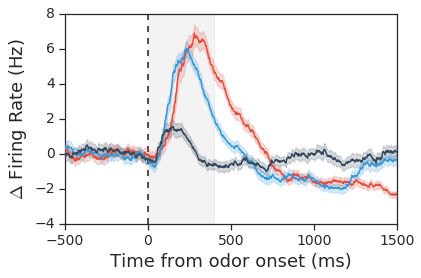

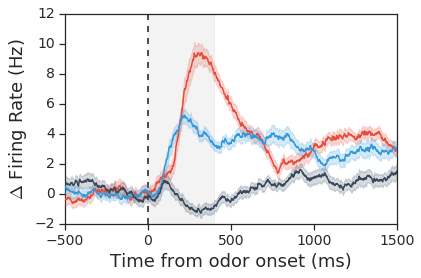

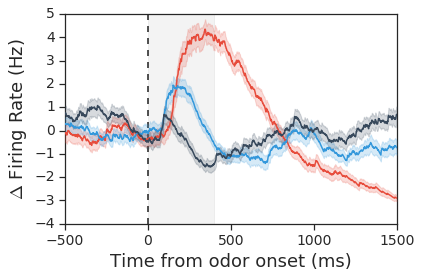

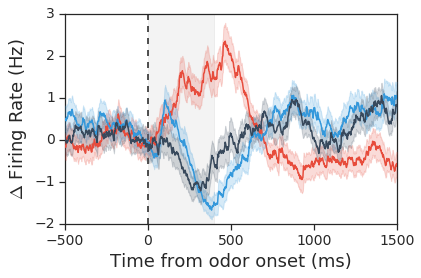

In [0]:
for i, cell in enumerate(fig3_da_psth['K'][0]):
  plot_varexp_cell(psth[cell-1], psth_sem[cell-1], times, cue='odor', window=(0., 400))


### GABAergic Timecourses: Figure 3d

In [0]:
reward_delivery_index = int(np.interp(2000., fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))
reward_window = int(np.interp(2400., fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))

odor_index = int(np.interp(0., fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))
window = 400
odor_window = int(np.interp(window, fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))
odor_off = int(np.interp(1500., fig3_ga_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))


In [0]:
# Since we are looking at cue-time, average over outcomes
ga_cue_resp = []
for i, cues in enumerate([(0,5), (1,4), (2,3)]):
  ga_cue_resp.append(np.hstack([fig3_ga_psth['PSTH'][:, cues[0]], fig3_ga_psth['PSTH'][:, cues[1]]]))
    
ga_cue_resp = np.array(ga_cue_resp)
ga_cue_resp = np.transpose(ga_cue_resp, (1, 0, 2, 3))

start, stop = 500, 1500
psth = np.nanmean(ga_cue_resp, -2)[..., start:stop]
num_trials = (1. - np.isnan(ga_cue_resp).astype(np.float32)).sum(-2)[..., start:stop]

psth_std = np.nanstd(ga_cue_resp, -2)[..., start:stop]
psth_sem = psth_std / np.sqrt(num_trials)
times = fig3_ga_psth['psthTimes'][0, start:stop]


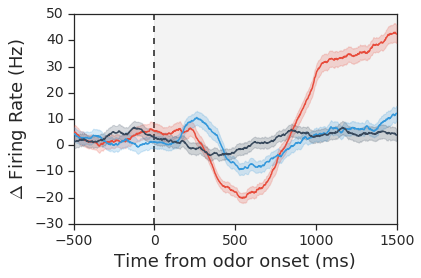

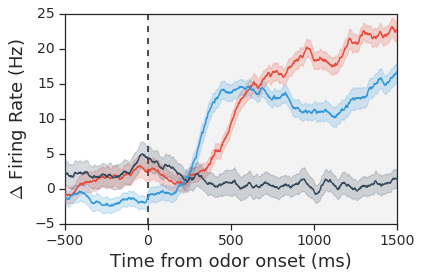

In [0]:
for i, cell in enumerate([ 26, 27]):
  plot_varexp_cell(psth[cell-1], psth_sem[cell-1], times, cue="odor", window=(0., 1500.))



### Non-Linearities: Extended data Figure 6

In [0]:
window = 400
reward_delivery_index = int(np.interp(2000., fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))
reward_window = int(np.interp(2400., fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))

odor_index = int(np.interp(0., fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))
odor_window = int(np.interp(window, fig3_da_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))

In [0]:
def compute_nonlins(task, threshold=0.05):
  num_cells = task.shape[0]
  lowers, interps, uppers = [], [], []
  pvals = np.zeros(num_cells)

  for cell in range(num_cells):
    # Randomization at least is unbiased
    # Randomly pair up as many trials of 10% and 90% as possible (min over trials)
    td10 = task[cell, 2, ~np.isnan(task[cell, 2])]
    td50 = task[cell, 1, ~np.isnan(task[cell, 1])]
    td90 = task[cell, 0, ~np.isnan(task[cell, 0])]

    ind1 = np.random.permutation(td10.shape[0])
    ind2 = np.random.permutation(td90.shape[0])
    min_len = min(len(ind1), len(ind2))

    # Compute the interpolation between these two values (for each paired trial)
    paired_means = ((td10[ind1[:min_len]] + td90[ind2[:min_len]])/2.).flatten()

    # Test the rank of the 50% response vs the interpolation
    upper = scipy.stats.mannwhitneyu(paired_means, td50, alternative='less').pvalue
    lower = scipy.stats.mannwhitneyu(paired_means, td50, alternative='greater').pvalue

    # Lower and upper are mutually exclusive
    pvals[cell] = upper

    # Significantly lower than interpolation (pessimistic estimator)
    if lower < threshold:
      lowers.append(cell)
    # Significanly higher than interpolation (optimistic estimator)
    elif upper < threshold:
      uppers.append(cell)
    # Neither (interpolating estimator)
    else:
      interps.append(cell)

  return pvals, lowers, interps, uppers

In [0]:
def plot_nonlins(cue_task, prefix="da_", gauss_norm=True):
  num_cells = cue_task.shape[0]

  pvals, low, intp, upr = compute_nonlins(cue_task)
  colors = asym_cmap(np.linspace(0., 1., num_cells))
  xs = np.array([.1, .5, .9])
  combined = []
  groupid = {}

  for j, (name, group) in enumerate([("Below", low), ("Interpolation", intp), ("Above", upr)]):
    fig = plt.figure()
    group10, group50, group90 = [], [], []
    for i, cell in enumerate(np.argsort(pvals)[::-1]):

      if cell not in group:
        continue

      td10 = cue_task[cell, 2, ~np.isnan(cue_task[cell, 2])]
      td50 = cue_task[cell, 1, ~np.isnan(cue_task[cell, 1])]
      td90 = cue_task[cell, 0, ~np.isnan(cue_task[cell, 0])]

      means = np.array([td10.mean(), td50.mean(), td90.mean()])
      if gauss_norm:
        # Gaussian normalized:
        all_means = np.nanmean(cue_task[cell])
        stdv = means.std()
      else:
        # Normalization to [0, 1]
        all_means = td10.mean()
        stdv = td90.mean() - td10.mean()

      means = (means - all_means)/stdv
      # Force into [0, 1] with high probabiltiy
      means = (means + 1.5)/3.

      group10.append((td10 - all_means)/stdv)
      group50.append((td50 - all_means)/stdv)
      group90.append((td90 - all_means)/stdv)

      c = asym_cmap(scipy.stats.norm.cdf(scipy.stats.ttest_1samp(group50[-1], 0.0).statistic, scale=3))
      plt.plot(xs, means, color=c, marker='.', alpha=0.5, label=str(cell), zorder=1)
      plt.scatter(xs, means, c=c, s=150, zorder=10)
      
      # Log the pvalues and group ID
      groupid[cell] = (pvals[cell], name)

    # Combine and store data
    comb = np.array([np.hstack(s) if len(s) else s for s in [group10, group50, group90]])
    combined.append(comb)

    # Plot bars in the background to communicate 'discrete' outcomes
    width = 0.2
    plt.bar(xs, [(c.mean()+1.5)/3. for c in comb], width=width, zorder=0,
           facecolor=(1, 1, 1, 0), linewidth=3., edgecolor="k")

    plt.xlim([-.1, 1.1])
    if not gauss_norm:
     plt.ylim([0., 1.1])
    else:
     plt.ylim([0., 1.])

    plt.xticks([0.1, 0.5, 0.9])
    plt.tick_params(labelsize=18)
    plt.xticks(xs, ["10%", "50%", "90%"])
    plt.ylabel("Firing rate (normalized)", fontsize=18)
    plt.xlabel("Probability of reward", fontsize=18)

    plt.gca().yaxis.tick_left()
    plt.gca().xaxis.tick_bottom()
    plt.tight_layout()
  
  return groupid

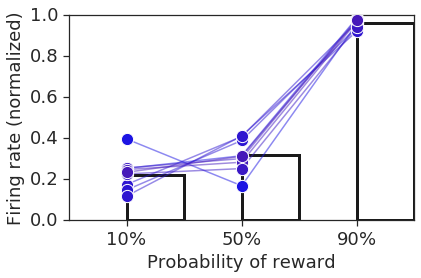

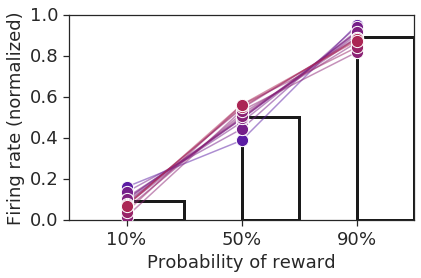

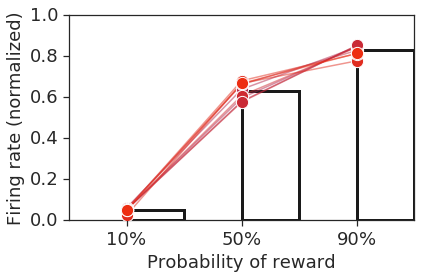

In [0]:
cue_task = cue_resp[..., odor_index:odor_window].mean(-1)
da_combined = plot_nonlins(cue_task)

In [0]:
odor_index = int(np.interp(0., fig3_ga_psth['psthTimes'][0], np.arange(cue_resp.shape[-1])))
odor_off = int(np.interp(1500., fig3_ga_psth['psthTimes'][0], np.arange(ga_cue_resp.shape[-1])))

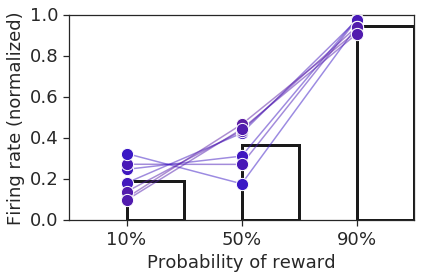

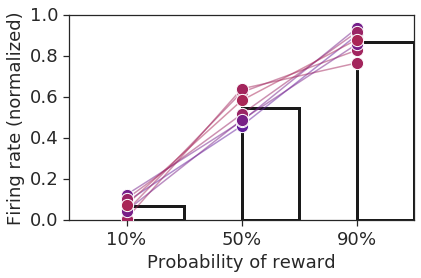

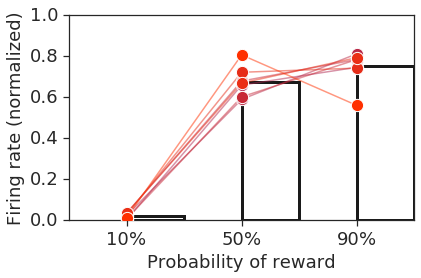

In [0]:
# Keep only type2
ga2_cue_resp = np.array([resp for i, resp in enumerate(ga_cue_resp) if fig3_ga_psth['is_type_2'][0, i] == 1])
ga_cue_task = ga2_cue_resp[..., odor_index:odor_off].mean(-1)
ga_combined = plot_nonlins(ga_cue_task, prefix="ga_")

### Simulations of non-linearity

In [0]:
conditions = ['90%', '50%', '10%']
probs = [0.9, 0.5, 0.1]
num_cues = len(probs)

num_cells = 31
num_steps = 5000
trials = 100
beta = 0.2
td_response_func = lambda r: r


In [0]:
values = np.zeros((trials, num_cues, num_cells))
alpha = np.random.random((trials, num_cells)) * beta

for trial in range(trials):
  for step in range(num_steps):
    for cue in range(num_cues):
      reward = 1. if np.random.random() < probs[cue] else 0.
      delta = reward - values[trial, cue]
      values[trial, cue] += alpha[trial] * td_response_func(delta)

ind = np.argsort(values)
values = np.array([[values[t,c,ind[t,c]] for c in range(num_cues)] for t in range(trials)])
ind = np.argsort(values.mean(1))
alpha = np.array([a[i] for a, i in zip(alpha, ind)])

In [0]:
distribution = np.zeros((trials, num_cues, num_cells))
alpha_pos = np.random.random((trials, num_cells))*beta
alpha_neg = np.random.random((trials, num_cells))*beta

for trial in range(trials):
  for step in range(num_steps):
    for cue in range(num_cues):
      reward = 1. if np.random.random() < probs[cue] else 0.
      delta = reward - distribution[trial, cue]

      valence = np.array(delta <= 0., dtype=np.float32)
      distribution[trial, cue] += (valence * alpha_neg[trial] + (1. - valence) * alpha_pos[trial]) * response_func(delta)



In [0]:
tau = alpha_pos / (alpha_pos + alpha_neg)
ind = np.argsort(tau)

tau = np.array([t[i] for t, i in zip(tau, ind)])
alpha_pos = np.array([t[i] for t, i in zip(alpha_pos, ind)])
alpha_neg = np.array([t[i] for t, i in zip(alpha_neg, ind)])
distribution = np.array([[distribution[t,c,ind[t]] for c in range(num_cues)] for t in range(trials)])


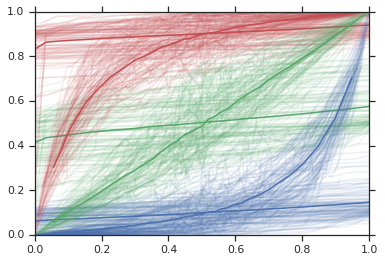

In [0]:
plt.plot(np.linspace(0., 1., num_cells), values.mean(0)[0], label='Classical TD', color='r')
plt.plot(np.linspace(0., 1., num_cells), values.mean(0)[1], label='Classical TD', color='g')
plt.plot(np.linspace(0., 1., num_cells), values.mean(0)[2], label='Classical TD', color='b')

for trial in range(trials):
  plt.plot(np.linspace(0., 1., num_cells), values[trial,0], label='Classical TD', color='r', alpha=0.1)
  plt.plot(np.linspace(0., 1., num_cells), values[trial,1], label='Classical TD', color='g', alpha=0.1)
  plt.plot(np.linspace(0., 1., num_cells), values[trial,2], label='Classical TD', color='b', alpha=0.1)

  
plt.plot(tau.mean(0), distribution.mean(0)[0], label='Distributional TD', color='r')
plt.plot(tau.mean(0), distribution.mean(0)[1], label='Distributional TD', color='g')
plt.plot(tau.mean(0), distribution.mean(0)[2], label='Distributional TD', color='b')

for trial in range(trials):
  plt.plot(tau[trial], distribution[trial,0], label='Distributional TD', color='r', alpha=0.1)
  plt.plot(tau[trial], distribution[trial,1], label='Distributional TD', color='g', alpha=0.1)
  plt.plot(tau[trial], distribution[trial,2], label='Distributional TD', color='b', alpha=0.1)


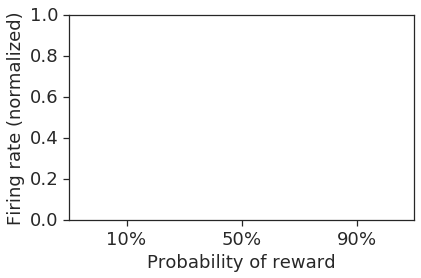

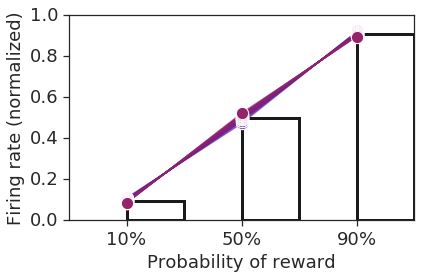

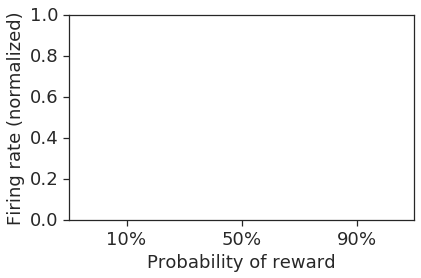

In [0]:
response = (alpha[:, None] * td_response_func(values))
response = np.transpose(response, (2, 1, 0))
_ = plot_nonlins(response, prefix="simTD_")

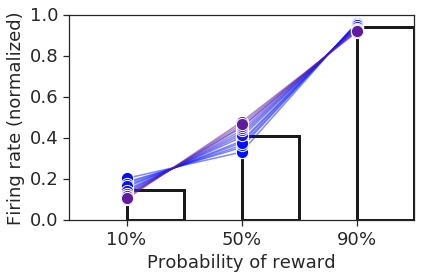

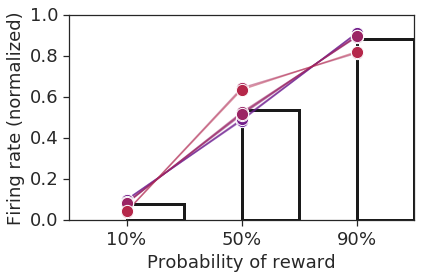

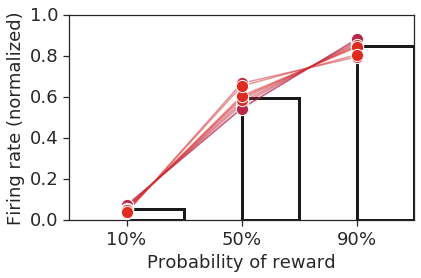

In [0]:
# Randomly pair a cue-predicted value and the scaling of the value baseline
# This is not needed for the observed effect, 
# but is more aligned with what the model would predict
rnd = distribution[:, :, np.random.permutation(31)]
response = (alpha_pos[:, None] * response_func(rnd))

response = np.transpose(response, (2, 1, 0))
_ = plot_nonlins(response, prefix="distTD_")


# Figure 4b and Extended Data Figure 9

In [0]:
fig5 = load_matlab("Figure5.mat")

In [0]:
zero_crossings = fig5['zeroCrossings'][:, 0]

In [0]:
def with_zero(values):
  if len(values) == 0:
    return values

  if values[0] >= 0:
    return np.hstack([[0.], values])
  return np.hstack([values, [0.]])

In [0]:
neg_scale, pos_scale = np.zeros(40), np.zeros(40)
for cell in range(zero_crossings.shape[0]):
    neg_scale[cell] = fig5['scaleFactNeg'][cell, 0]
    pos_scale[cell] = fig5['scaleFactPos'][cell, 0]


In [0]:
eta = pos_scale/(pos_scale + neg_scale)

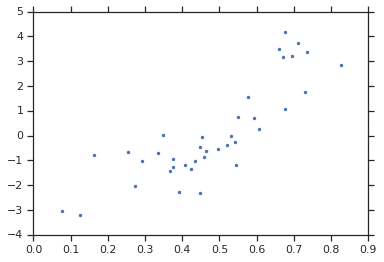

In [0]:
plt.scatter(eta, zero_crossings)

In [0]:
red = (240/256., 128/256., 17/256., 1.)
blue = (0/256., 124/256., 104/256., 1.)


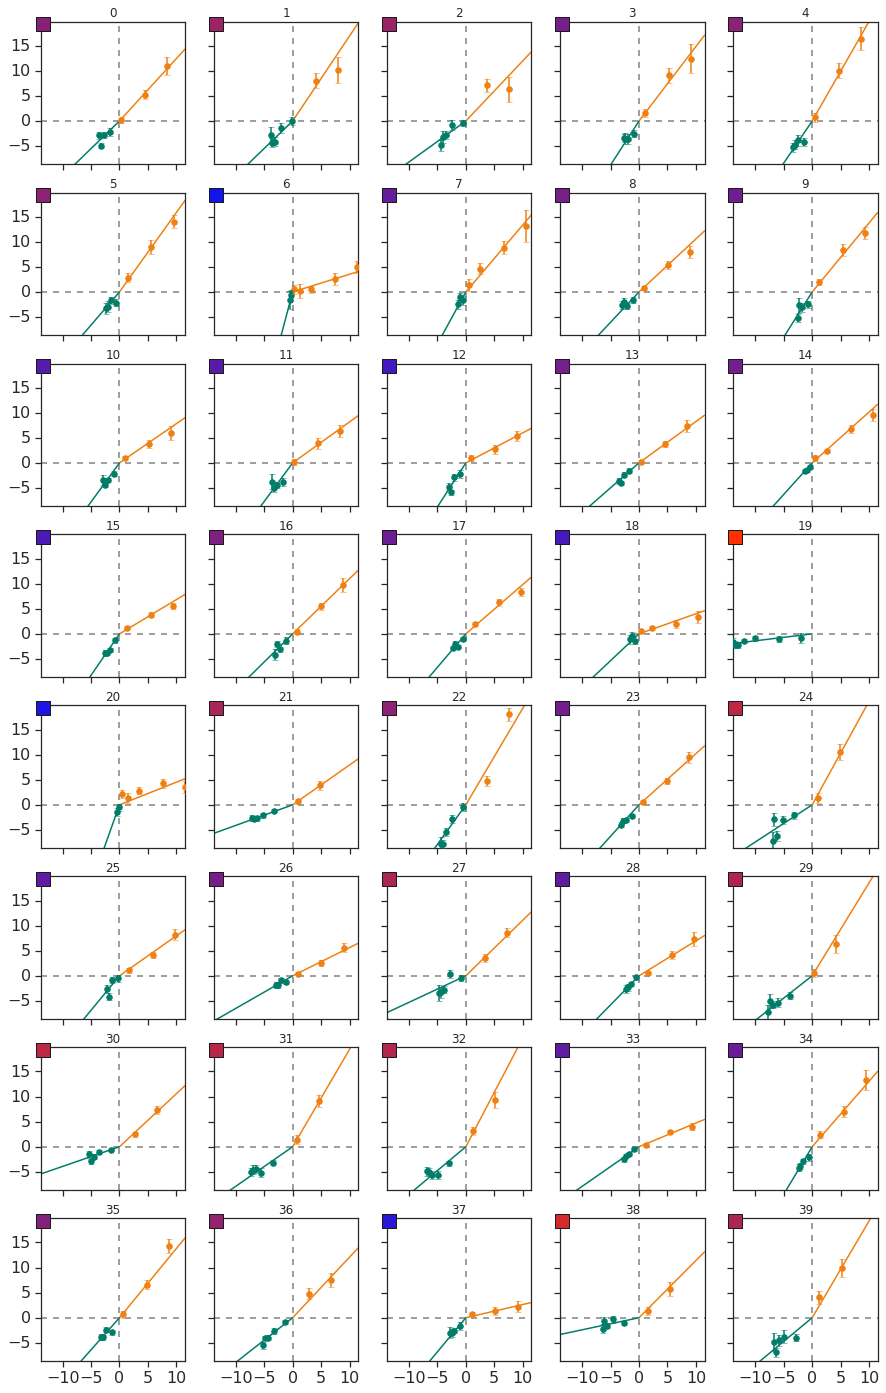

In [0]:
fig = plt.figure(figsize=(3*5, 3*8))
minUAx = np.array([fig5['utilityAxisPerCell'][c] for c in range(zero_crossings.shape[0])]).min()
maxUAx = np.array([fig5['utilityAxisPerCell'][c] for c in range(zero_crossings.shape[0])]).max()
minY = np.array([np.nanmean(fig5['perCell'][c], -1) for c in range(zero_crossings.shape[0])]).min() * 1.1
maxY = np.array([np.nanmean(fig5['perCell'][c], -1) for c in range(zero_crossings.shape[0])]).max() * 1.1

offset = 0.
ord_scale = False

ax = plt.subplot(8, 5, 1)
for cell in range(zero_crossings.shape[0]):
  ax2 = plt.subplot(8, 5, cell + 1, sharey=ax, sharex=ax)
  xs = fig5['utilityAxisPerCell'][cell]
  pospart = xs >= 0.
  negpart = xs <= 0.

  xxs = np.arange(len(xs))
  xxs -= negpart.sum()
  
  sems = scipy.stats.sem(fig5['perCell'][cell], axis=1, nan_policy='omit').data
  means = np.nanmean(fig5['perCell'][cell], -1)
  for i in range(len(xs)):
    if ord_scale:
      # Ordinal xscale
      plt.scatter(x=xxs[i] + offset, y=means[i], 
                  facecolors=blue if xs[i] < 0 else red,
                  edgecolors=blue if xs[i] < 0 else red, zorder=3,
                  marker='o', s=30, linewidths=1.)
      plt.errorbar(x=xxs[i], y=means[i], color=blue if xs[i] < 0 else red, 
                   yerr=sems[i], marker="", linestyle="", zorder=5)
    else:
      # True xscale
      plt.scatter(x=xs[i], y=means[i], 
                  facecolors=blue if xs[i] < 0 else red,
                  edgecolors=blue if xs[i] < 0 else red, zorder=3,
                  marker='o', s=30, linewidths=1.)
      plt.errorbar(x=xs[i], y=means[i], color=blue if xs[i] < 0 else red, 
                   yerr=sems[i], marker="", linestyle="", zorder=5)

  if ord_scale:
    # Linear response
    plt.plot(with_zero(xxs[pospart] + offset), pos_scale[cell]*with_zero(xs[pospart]), color=red)
    plt.plot(with_zero(xxs[negpart] - offset), neg_scale[cell]*with_zero(xs[negpart]), color=blue)
  else:
    # Linear response
    plt.plot(np.arange(0., maxUAx, 0.01), pos_scale[cell]*np.arange(0., maxUAx, 0.01), color=red)
    plt.plot(np.arange(minUAx, 0., 0.01), neg_scale[cell]*np.arange(minUAx, 0., 0.01), color=blue)

  plt.axhline(linestyle='--', color='gray', zorder=1)
  plt.axvline(linestyle='--', color='gray', zorder=1)
  plt.ylim([minY, maxY])
  
  if ord_scale:
    plt.xlim([-4.2, 4.2])
    plt.xticks([-3., 0., 3.])
  else:
    plt.xlim([minUAx, maxUAx])

  plt.gca().tick_params(labelsize=16)
  
  
  ax2.yaxis.tick_left()
  ax2.xaxis.tick_bottom()
  plt.title(str(cell))
  
  if cell % 5 > 0:
    plt.setp(ax2.get_yticklabels(), visible=False)

  if cell < 7*5:
    plt.setp(ax2.get_xticklabels(), visible=False)

for cell in range(zero_crossings.shape[0]):
  ax2 = plt.subplot(8, 5, cell + 1, sharey=ax, sharex=ax)
  x = ax2.get_xlim()[0] * .99 + ax2.get_xlim()[1] * 0.02
  y = ax2.get_ylim()[1] * .98 + ax2.get_ylim()[0] * 0.02
  t = eta[cell]
  if np.isnan(t):
    t = 1.
  plt.scatter([x], [y], facecolor=asym_cmap(t), edgecolor='k',
              s=200, zorder=100, clip_on=False, marker='s')


### Collage Plot
This looks at a variety of cells showing their slopes with all cells being zero-crossing aligned.

In [0]:
cells = fig5['cellsToPlot'][0]

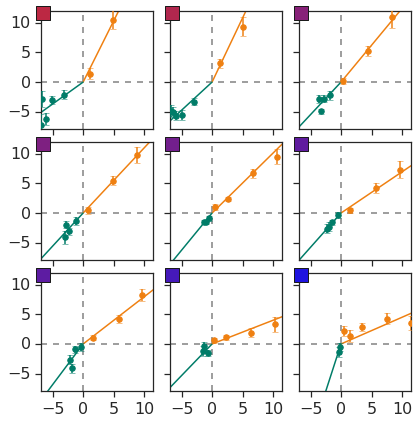

In [0]:
fig = plt.figure(figsize=(2*3, 2*3))
ax = plt.subplot(3, 3, 1)
minUAx = np.array([fig5['utilityAxisPerCell'][c-1] for c in cells]).min()
maxUAx = np.array([fig5['utilityAxisPerCell'][c-1] for c in cells]).max()
minY = np.array([np.nanmean(fig5['perCell'][c-1], -1) for c in cells]).min() * 1.1
maxY = np.array([np.nanmean(fig5['perCell'][c-1], -1) for c in cells]).max() * 1.1

offset = 0.
ord_scale = False

for j, cell in enumerate(cells):
  cell -= 1
  ax2 = plt.subplot(3, 3, j + 1)
  xs = fig5['utilityAxisPerCell'][cell]
  pospart = xs >= 0.
  negpart = xs <= 0.

  xxs = np.arange(len(xs))
  xxs -= negpart.sum()

  sems = scipy.stats.sem(fig5['perCell'][cell], axis=1, nan_policy='omit').data
  means = np.nanmean(fig5['perCell'][cell], -1)
  for i in range(len(xs)):
    if ord_scale:
      # Ordinal xscale
      plt.scatter(x=xxs[i] + offset, y=means[i], 
                  facecolors=blue if xs[i] < 0 else red,
                  edgecolors=blue if xs[i] < 0 else red, zorder=3,
                  marker='o', s=30, linewidths=1.)
      plt.errorbar(x=xxs[i], y=means[i], color=blue if xs[i] < 0 else red, 
                   yerr=sems[i], marker="", linestyle="", zorder=5)
    else:
      # True xscale
      plt.scatter(x=xs[i], y=means[i], 
                  facecolors=blue if xs[i] < 0 else red,
                  edgecolors=blue if xs[i] < 0 else red, zorder=3,
                  marker='o', s=30, linewidths=1.)
      plt.errorbar(x=xs[i], y=means[i], color=blue if xs[i] < 0 else red, 
                   yerr=sems[i], marker="", linestyle="", zorder=5)


  if ord_scale:
    # Linear response
    plt.plot(with_zero(xxs[pospart] + offset), pos_scale[cell]*with_zero(xs[pospart]), color=red)
    plt.plot(with_zero(xxs[negpart] - offset), neg_scale[cell]*with_zero(xs[negpart]), color=blue)
  else:
    # Linear response
    plt.plot(np.arange(0., maxUAx, 0.01), pos_scale[cell]*np.arange(0., maxUAx, 0.01), color=red)
    plt.plot(np.arange(minUAx, 0., 0.01), neg_scale[cell]*np.arange(minUAx, 0., 0.01), color=blue)

  plt.axhline(linestyle='--', color='gray', zorder=1)
  plt.axvline(linestyle='--', color='gray', zorder=1)
  plt.ylim([minY, maxY])
  
  if ord_scale:
    plt.xlim([-4.2, 4.2])
    plt.xticks([-3., 0., 3.])
  else:
    plt.xlim([minUAx, maxUAx])

  plt.gca().tick_params(labelsize=16)
  
  
  ax2.yaxis.tick_left()
  ax2.xaxis.tick_bottom()
  
  if j % 3 > 0:
    plt.setp(ax2.get_yticklabels(), visible=False)

  if j < 6:
    plt.setp(ax2.get_xticklabels(), visible=False)

for j, cell in enumerate(cells):
  cell -= 1
  ax2 = plt.subplot(3, 3, j + 1)
  x = ax2.get_xlim()[0] * .98 + ax2.get_xlim()[1] * 0.02
  y = ax2.get_ylim()[1] * .98 + ax2.get_ylim()[0] * 0.02
  plt.scatter([x], [y], facecolor=asym_cmap(eta[cell]), edgecolor='k',
              s=200, zorder=100, clip_on=False, marker='s')

plt.tight_layout()

### Rescaled By Neg Plot: Figure 4e

This shows the zero-crossing aligned responses for all cells overlayed, with the responses rescaled by the negative slope. Under previous theories this should eliminate variance in the positive domain, but as we see it does not.

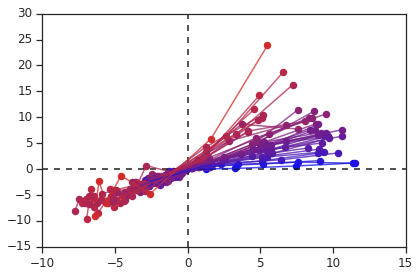

In [0]:
ind = np.argsort(zero_crossings)
fig = plt.figure()
for cell in range(zero_crossings.shape[0]):
  # Outlier cell, does not change the result but is an extreme outlier
  # as it has no positive responses. Comment out to see it included.
  if cell == 19: 
    continue

  xs = fig5['utilityAxisPerCell'][cell]
  means = np.nanmean(fig5['perCell'][cell], -1) / neg_scale[cell]
  plt.plot(xs, means, color=asym_cmap(eta[cell]), alpha=0.75)
  plt.scatter(xs, means, s=30, linewidth=2., alpha=1.,
              facecolors=asym_cmap(eta[cell]),
              edgecolor=asym_cmap(eta[cell]))

plt.axvline(linestyle='--', color='k', zorder=1)
plt.axhline(linestyle='--', color='k', zorder=1)

plt.gca().tick_params(labelsize=12)
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
plt.tight_layout()


### Optimism (eta) with variance: Figure 4c

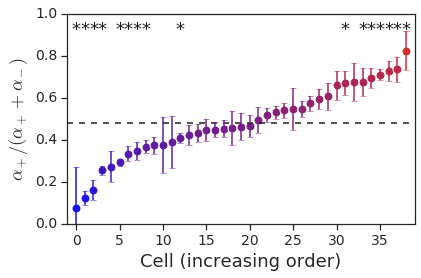

In [0]:
eta = pos_scale/(pos_scale + neg_scale)
ind = np.argsort(eta)
eta_pvals = fig5['asym_pvals'][0]

fig = plt.figure()

for i in range(len(ind)):
  sem = fig5['asymSE'][0, ind[i]]
  plt.errorbar([i], eta[ind[i]], yerr=sem,
               color=asym_cmap(eta[ind[i]]))
  plt.scatter([i], eta[ind[i]], c=asym_cmap(eta[ind[i]]), s=80)
  if eta_pvals[ind[i]] < 0.05:
    plt.text(i-.51, 0.9, '*', color='k', fontsize=18)

plt.axhline(y=np.nanmean(eta), linestyle='--', color='k', zorder=1)

plt.ylim([0.0, 1.])
plt.xlim([-1., 39])
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()

plt.tick_params(labelsize=14)
plt.xlabel("Cell (increasing order)", fontsize=18)
plt.ylabel("$\\alpha_+/(\\alpha_+ + \\alpha_-)$", fontsize=18)
plt.tight_layout()


### Correlation analysis between eta and zero-crossing

In [0]:
true_zeros = np.interp(zero_crossings, fig5['utilityAxis'][0], juice_amounts)

R, pval = scipy.stats.pearsonr(eta[~np.isnan(eta)], zero_crossings[~np.isnan(eta)])

R_neg, pval_neg = scipy.stats.pearsonr(neg_scale[~np.isnan(neg_scale)], zero_crossings[~np.isnan(neg_scale)])
R_pos, pval_pos = scipy.stats.pearsonr(pos_scale[~np.isnan(pos_scale)], zero_crossings[~np.isnan(pos_scale)])

print(R, pval, R_pos, pval_pos, R_neg, pval_neg)

(0.8381731166785322, 2.7896990894698965e-11, 0.6009810580876243, 5.2196529180766934e-05, nan, 1.0)


2.7896990894698965e-11
5.2196529180766934e-05
1.0


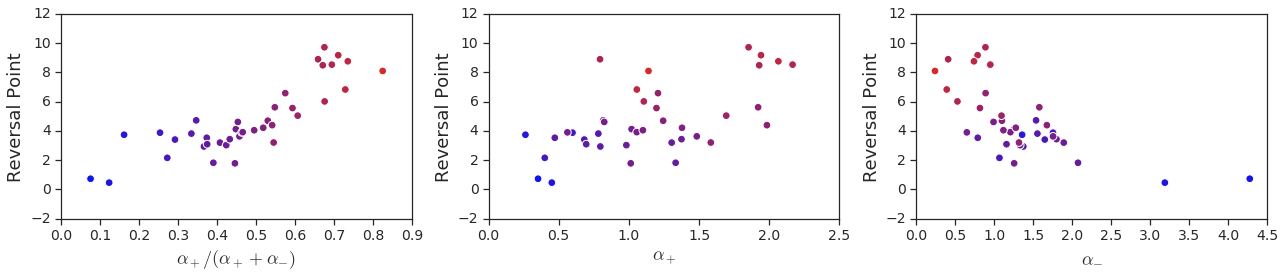

In [0]:
ind = np.argsort(eta)
if np.isnan(eta[ind[-1]]):
  ind = ind[:-1]

fig = plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.scatter(eta[ind], true_zeros[ind], c=asym_cmap(eta[ind]), s=60)
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
print(pval)

plt.xlabel("$\\alpha_+ / (\\alpha_+ + \\alpha_{-})$", fontsize=18)
plt.ylabel("Reversal Point", fontsize=18)

plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 2)
plt.scatter(pos_scale[ind], true_zeros[ind], c=asym_cmap(eta[ind]), s=60)
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
print(pval_pos)

plt.xlabel("$\\alpha_+$", fontsize=18)
plt.ylabel("Reversal Point", fontsize=18)

plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 3)
plt.scatter(neg_scale[ind], true_zeros[ind], c=asym_cmap(eta[ind]), s=60)
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
print(pval_neg)

plt.xlabel("$\\alpha_{-}$", fontsize=18)
plt.ylabel("Reversal Point", fontsize=18)

plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()
plt.tick_params(labelsize=14)
plt.tight_layout()


## Extended Data Figure 5lm

In [0]:
var_exp_task = load_task('eshel2016/Variable-Expectation/')

Loaded 31 cell recordings...


In [0]:
### Windows
psth_window = (-1000, 3000)   # In units of ms
psth_resolution = 1           # In units of ms
baseline_window = (-1000, 0)  # In units of ms

# Number of bins in the PSTH
psth_len = 1 + np.ceil(psth_window[1] - psth_window[0]) / psth_resolution
# Relative time of each bin in the PSTH
psth_times = np.linspace(psth_window[0], psth_window[1], psth_len)

# Immediately after cue
cue_period = times_to_indices((0, 400), psth_window, psth_resolution)

### Smoothing kernel
smoothing_time_const = 20     # 20 is what Eschel et al. used (units of ms)
smoothing_func = lambda t: (1. - np.exp(-t)) * np.exp(-t/smoothing_time_const)
smoothing_kernel = smoothing_func(
    np.arange(0., 2.5 * smoothing_time_const, psth_resolution))
smoothing_kernel = np.ones(smoothing_time_const)
smoothing_kernel /= smoothing_kernel.sum()

### Which animals to use cells from
all_animals = list(sorted(set([cell.animal for cell in var_exp_task])))
num_trials = 5

cmap_airpuff = plt.cm.rainbow
cmap_rewarded = plt.cm.bone_r


In [0]:
edfigure5_data = compute_firing_rate(var_exp_task, psth_window=psth_window,
                                   psth_resolution=psth_resolution, 
                                   baseline_window=baseline_window,
                                   smoothing_kernel=smoothing_kernel)


In [0]:
free_task = collapse_range(edfigure5_data, cue_period)

valid_cells = [cell for cell in range(len(free_task)) if 3 in free_task[cell] and 8 in free_task[cell]]
rewarded = [free_task[cell][3] for cell in valid_cells]
airpuff = [free_task[cell][8] for cell in valid_cells]

order = np.argsort([cell.mean() for cell in airpuff])
valid_cells = [valid_cells[i] for i in order]
rewarded = [rewarded[i] for i in order]
airpuff = [airpuff[i] for i in order]

all_animals = list(sorted(set([var_exp_task[cell].animal for cell in valid_cells])))


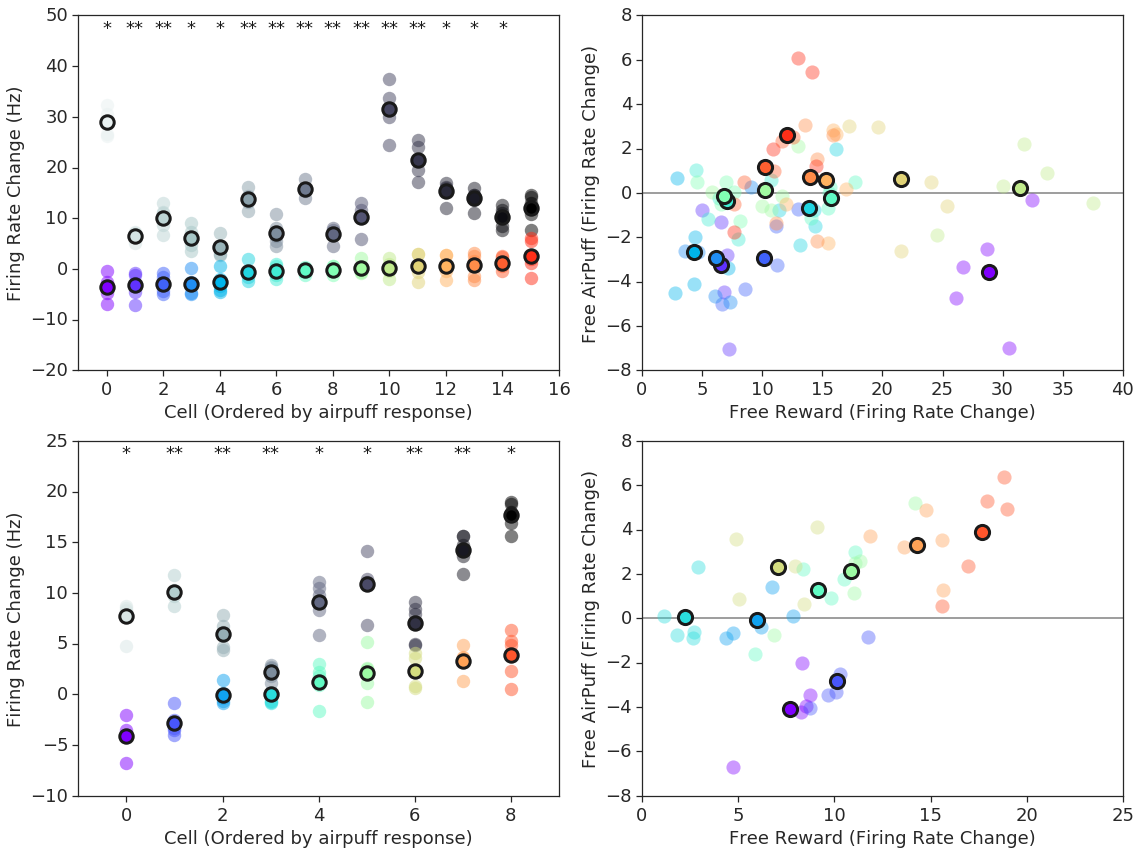

In [0]:
fig = plt.figure(figsize=(8*2,6*len(all_animals)))
colors = {}

for a, name in enumerate(all_animals):
  colors[name] = {}
  
  within_animal = [c for c in range(len(rewarded)) if var_exp_task[valid_cells[c]].animal == name]
  rewarded_tds = np.array([[rewarded[cell][i::num_trials].mean() for i in range(num_trials)] for cell in within_animal])
  airpuff_tds = np.array([[airpuff[cell][i::num_trials].mean() for i in range(num_trials)] for cell in within_animal])
  
  pvals = np.array([[scipy.stats.ttest_ind(rewarded_tds[i], rewarded_tds[j]).pvalue for j in range(len(within_animal))] for i in range(len(within_animal))])
  lefts, rights = [], []
  for cell in range(len(within_animal)):
    colors[name][cell] = cmap_airpuff(float(cell)/len(within_animal))
    plt.subplot(len(all_animals), 2, 2*a + 1)
    
    plt.scatter(np.ones_like(rewarded_tds[cell]) * cell, rewarded_tds[cell], alpha=0.5, c=cmap_rewarded(float(cell+1)/len(within_animal)), s=180, linewidth=0)
    plt.scatter(np.ones_like(airpuff_tds[cell]) * cell, airpuff_tds[cell], alpha=0.5, c=colors[name][cell], s=180, linewidth=0)
    
    plt.scatter(np.ones(1) * cell, rewarded_tds[cell].mean(keepdims=True), c=cmap_rewarded(float(cell+1)/len(within_animal)), s=180, linewidth=3, edgecolor='k')
    plt.scatter(np.ones(1) * cell, airpuff_tds[cell].mean(keepdims=True), c=colors[name][cell], s=180, linewidth=3, edgecolor='k')
    
    if cell > 0 and (pvals[cell, cell-1] < 0.05):
      lefts.append(cell)
    if cell < len(within_animal) - 1 and (pvals[cell, cell+1] < 0.05):
      rights.append(cell)
      
    plt.gca().yaxis.tick_left()
    plt.gca().xaxis.tick_bottom()

      
    plt.subplot(len(all_animals), 2, 2*a + 2)
    plt.scatter(rewarded_tds[cell].mean(keepdims=True), airpuff_tds[cell].mean(keepdims=True), c=colors[name][cell], s=200, zorder=10, linewidth=3, edgecolor='k')
    for i in range(len(rewarded_tds[cell])):
      plt.scatter(rewarded_tds[cell][i], airpuff_tds[cell][i], c=colors[name][cell], s=200, alpha=0.4, linewidth=0)
    

  plt.subplot(len(all_animals), 2, 2*a + 2)
  plt.tick_params(labelsize=18)
  plt.ylabel("Free AirPuff (Firing Rate Change)", fontsize=18)
  plt.xlabel("Free Reward (Firing Rate Change)", fontsize=18)

  plt.axhline(y=0, color='gray', zorder=0)
  plt.axvline(x=0, color='gray', zorder=0)
  plt.gca().yaxis.tick_left()
  plt.gca().xaxis.tick_bottom()
  
  plt.subplot(len(all_animals), 2, 2*a + 1)
  plt.xlabel("Cell (Ordered by airpuff response)", fontsize=18)
  plt.ylabel("Firing Rate Change (Hz)", fontsize=18)
  plt.tick_params(labelsize=18)
  _ = plt.xlim([-1, len(within_animal)])
  lims = plt.ylim()
  xlm = plt.xlim()
  lefts = np.array(lefts, dtype=np.float32)
  rights = np.array(rights, dtype=np.float32)
  for l in np.unique(lefts.tolist() + rights.tolist()):
    text = ""
    if l in lefts:
      text += "*"
    if l in rights:
      text += "*"
    plt.text(l, lims[1]*.95, text,
         {'color': 'k', 'fontsize': 18, 'ha': 'center', 'va': 'center'})

plt.tight_layout()

### Simulations

In [0]:
conditions = ['Free Reward', 'Free AirPuff']
all_animals = list(sorted(set(
    [var_exp_task[cell].animal for cell in range(len(var_exp_task)) \
     if (3 in edfigure5_data[cell]) and (8 in edfigure5_data[cell])])))
num_cells = max([len([
    cell for cell in range(len(var_exp_task)) if (3 in edfigure5_data[cell]) and \
    (8 in edfigure5_data[cell]) and (var_exp_task[cell].animal == animal)]) \
                 for animal in all_animals])

num_steps = 50000
trials = num_trials = 5
reward_magnitude = 1.
airpuff_magnitude = -.25

cmap_airpuff = plt.cm.rainbow
cmap_rewarded = plt.cm.bone_r


In [0]:
values = np.array(sorted(np.random.normal(scale=0.05, size=num_cells)))
values = values[None] + np.random.normal(scale=0.0, size=(trials, num_cells))

In [0]:
# Common positive scaling
alpha = np.random.random(num_cells)
alpha_pos = alpha

# Only difference is the negative learning rate
alpha_neg = np.random.random(num_cells)

# We order by implied quantile-target
tau = alpha_pos / (alpha_pos + alpha_neg)
ind = np.argsort(tau)
alpha_pos = alpha_pos[ind]
alpha_neg = alpha_neg[ind]
alpha = alpha[ind]

all_algorithms = [(alpha * response_func(reward_magnitude - values), alpha * response_func(airpuff_magnitude - values))]

delta = response_func(reward_magnitude - values)
valence = np.array(delta <= 0., dtype=np.float32)
responses = valence * alpha_neg + (1. - valence) * alpha_pos
reward_td = responses * (delta)

delta = response_func(airpuff_magnitude - values)
valence = np.array(delta <= 0., dtype=np.float32)
responses = valence * alpha_neg + (1. - valence) * alpha_pos
airpuff_td = responses * (delta)

all_algorithms.append((reward_td, airpuff_td))
all_algorithms = np.array(all_algorithms)
all_algorithms = np.transpose(all_algorithms, (0, 1, 3, 2))

algorithm_names = ['TD', 'DistTD']


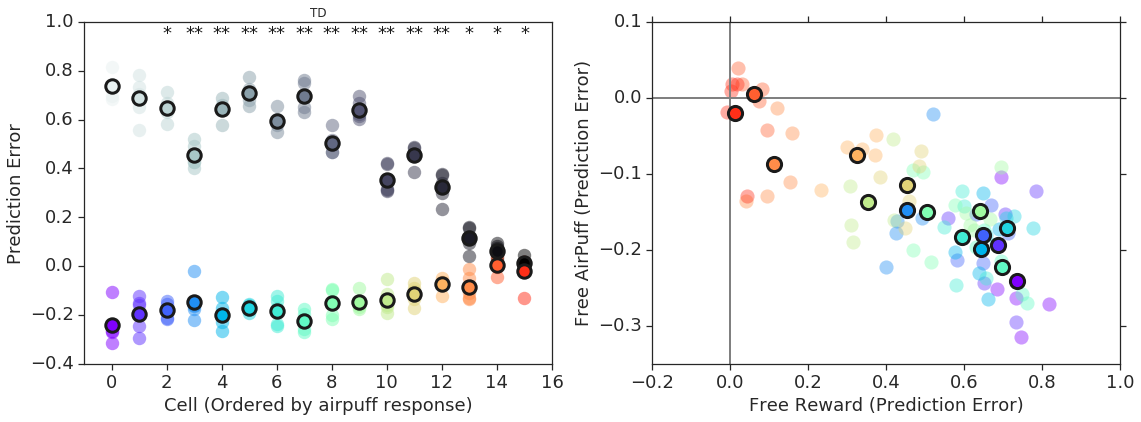

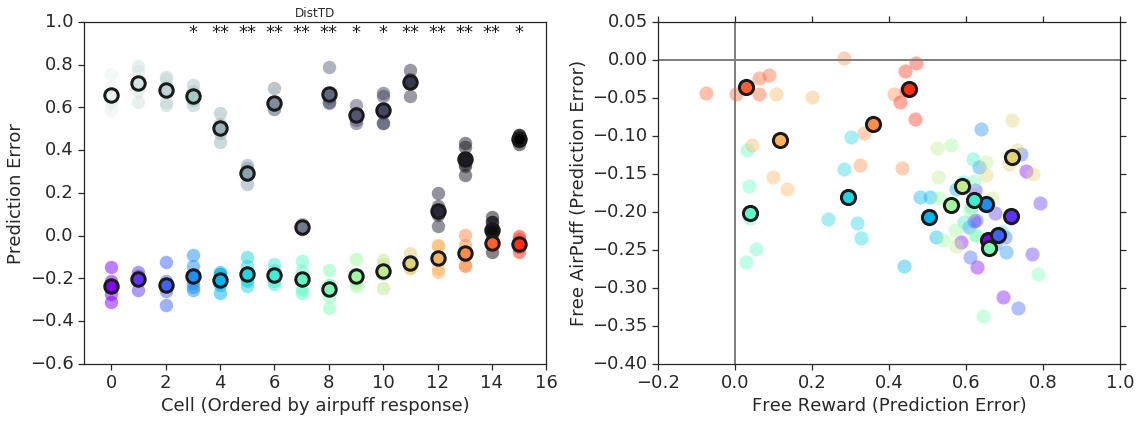

In [0]:
colors = {}
noise_scale = 0.05

for a, name in enumerate(algorithm_names):
  fig = plt.figure(figsize=(8*2,6))
  colors[name] = {}
  
  rewarded_tds, airpuff_tds = all_algorithms[a]
  
  # Sorting by response
  ind = np.argsort(airpuff_tds.T)
  rewarded_tds = np.array([t[i] for t, i in zip(rewarded_tds.T, ind)]).T
  airpuff_tds = np.array([t[i] for t, i in zip(airpuff_tds.T, ind)]).T
  
  rewarded_tds += np.random.normal(scale=noise_scale, size=rewarded_tds.shape)
  airpuff_tds += np.random.normal(scale=noise_scale, size=airpuff_tds.shape)
  
  pvals = np.array([[scipy.stats.ttest_ind(rewarded_tds[i], rewarded_tds[j]).pvalue for j in range(len(rewarded_tds))] for i in range(len(rewarded_tds))])
  lefts, rights = [], []
  for cell in range(len(rewarded_tds)):
    colors[name][cell] = cmap_airpuff(float(cell)/len(rewarded_tds))
    plt.subplot(1, 2, 1)
    
    plt.scatter(np.ones_like(rewarded_tds[cell]) * cell, rewarded_tds[cell], alpha=0.5, c=cmap_rewarded(float(cell+1)/len(rewarded_tds)), s=180, linewidth=0)
    plt.scatter(np.ones_like(airpuff_tds[cell]) * cell, airpuff_tds[cell], alpha=0.5, c=colors[name][cell], s=180, linewidth=0)
    
    plt.scatter(np.ones(1) * cell, rewarded_tds[cell].mean(keepdims=True), c=cmap_rewarded(float(cell+1)/len(rewarded_tds)), s=180, linewidth=3, edgecolor='k')
    plt.scatter(np.ones(1) * cell, airpuff_tds[cell].mean(keepdims=True), c=colors[name][cell], s=180, linewidth=3, edgecolor='k')
    
    if cell > 0 and (pvals[cell, cell-1] < 0.05):
      lefts.append(cell)
    if cell < len(rewarded_tds) - 1 and (pvals[cell, cell+1] < 0.05):
      rights.append(cell)
      
    plt.subplot(1, 2, 2)
    
    plt.scatter(rewarded_tds[cell].mean(keepdims=True), airpuff_tds[cell].mean(keepdims=True), c=colors[name][cell], s=200, zorder=10, linewidth=3, edgecolor='k')
    for i in range(len(rewarded_tds[cell])):
      plt.scatter(rewarded_tds[cell][i], airpuff_tds[cell][i], c=colors[name][cell], s=200, alpha=0.4, linewidth=0)

  plt.subplot(1, 2, 2)
  plt.tick_params(labelsize=18)
  plt.ylabel("Free AirPuff (Prediction Error)", fontsize=18)
  plt.xlabel("Free Reward (Prediction Error)", fontsize=18)

  plt.axhline(y=0, color='gray', zorder=1, linewidth=2)
  plt.axvline(x=0, color='gray', zorder=1, linewidth=2)

  plt.subplot(1, 2, 1)
  plt.tick_params(labelsize=18)
  plt.title(name)
  plt.xlabel("Cell (Ordered by airpuff response)", fontsize=18)
  plt.ylabel("Prediction Error", fontsize=18)
  plt.gca().yaxis.tick_left()
  plt.gca().xaxis.tick_bottom()

  _ = plt.xlim([-1, len(rewarded_tds)])
  lims = plt.ylim()
  xlm = plt.xlim()
  lefts = np.array(lefts, dtype=np.float32)
  rights = np.array(rights, dtype=np.float32)
  for l in np.unique(lefts.tolist() + rights.tolist()):
    text = ""
    if l in lefts:
      text += "*"
    if l in rights:
      text += "*"
    plt.text(l, lims[1]*.95, text,
         {'color': 'k', 'fontsize': 18, 'ha': 'center', 'va': 'center'})
  
  plt.tight_layout()


# Coupling Experiment: Extended Daata Figure opq

In [0]:
num_cells = 50
num_steps = 20000
trials = 10
beta = 0.1
prob_reward = 0.5

variances = [0.01, 10., 30]

td_response_func = lambda r: r


In [0]:
def make_smooth(N, sigma=1.):
  smoother = np.eye(N)*0.
  for i in range(N-1):
    smoother += np.diag(np.ones(N - 1 - i) * i+1., k=i+1)
    smoother += np.diag(np.ones(N - 1 - i) * i+1., k=-(i+1))
  
  smoother = scipy.stats.norm.pdf(smoother, scale=sigma)
  return smoother / smoother.sum(1, keepdims=True)



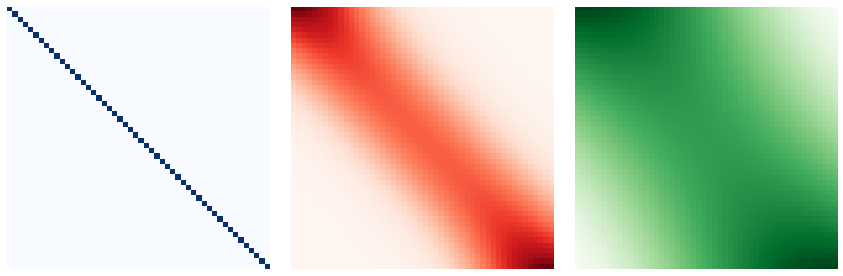

In [0]:
cmaps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
fig = plt.figure(figsize=(4*len(variances), 4))
for i, v in enumerate(variances):
  ax = plt.subplot(1, len(variances), i+1)
  T = make_smooth(num_cells, sigma=v)
  plt.imshow(T, interpolation='nearest', cmap=cmaps[i])
  plt.setp(ax.get_yticklabels(), visible=False)
  plt.setp(ax.get_xticklabels(), visible=False)
  ax.axis('off')

plt.tight_layout()

In [0]:
distribution = np.zeros((trials, len(variances), num_cells))
alpha_pos = np.array([np.linspace(0., 1., num_cells+2)[1:-1] for _ in range(trials)])
alpha_neg = 1. - alpha_pos

transfers = [make_smooth(num_cells, sigma=v) for v in variances]

for trial in range(trials):
  for step in range(num_steps):
    for s, sig in enumerate(variances):
      reward = 1. if np.random.random() < prob_reward else 0.
      delta = reward - distribution[trial, s]

      valence = np.array(delta <= 0., dtype=np.float32)
      distribution[trial, s] += np.dot(transfers[s], (valence * alpha_neg[trial] + (1. - valence) * alpha_pos[trial]) * np.sign(delta)) * beta


In [0]:
tau = alpha_pos / (alpha_pos + alpha_neg)
ind = np.argsort(tau)

tau = np.array([t[i] for t, i in zip(tau, ind)])
alpha_pos = np.array([t[i] for t, i in zip(alpha_pos, ind)])
alpha_neg = np.array([t[i] for t, i in zip(alpha_neg, ind)])
distribution = np.array([[distribution[t,c,ind[t]] for c in range(len(variances))] for t in range(trials)])


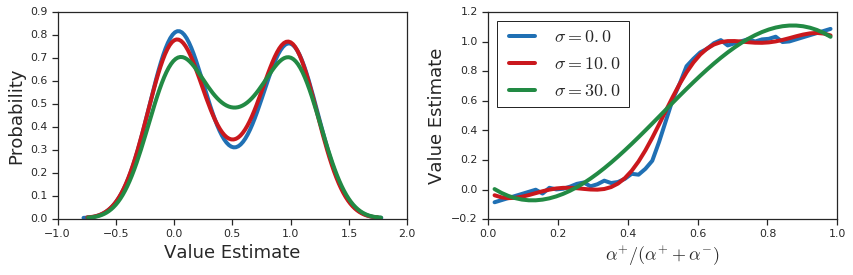

In [0]:
sns.set_style('white')
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.kdeplot(distribution.mean(0)[0], color=cmaps[0](.75), linewidth=4)
sns.kdeplot(distribution.mean(0)[1], color=cmaps[1](.75), linewidth=4)
sns.kdeplot(distribution.mean(0)[2], color=cmaps[2](.75), linewidth=4)
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
plt.xlabel("Value Estimate", fontsize=18)
plt.ylabel("Probability", fontsize=18)

ax = plt.subplot(1, 2, 2)
for s, sig in enumerate(variances):
  plt.plot(tau.mean(0), distribution.mean(0)[s], label='$\\sigma = %.1f$' % sig, color=cmaps[s](.75), linewidth=4.)

ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
plt.ylabel("Value Estimate", fontsize=18)
plt.xlabel("$\\alpha^{+}/(\\alpha^{+} + \\alpha^{-})$", fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.tight_layout()

# Cue-delivery correlation

In [0]:
var_exp_task = load_task('eshel2016/Variable-Expectation/')
var_reward_task = load_task('eshel2016/variable-reward/Light-ID dopamine/')


Loaded 31 cell recordings...
Loaded 40 cell recordings...


In [0]:
### Windows
psth_window = (-1000, 3000)   # In units of ms
psth_resolution = 1           # In units of ms
baseline_window = (-1000, 0)  # In units of ms
base_period = times_to_indices((-1000, 0), psth_window, psth_resolution)

# Number of bins in the PSTH
psth_len = 1 + np.ceil(psth_window[1] - psth_window[0]) / psth_resolution
# Relative time of each bin in the PSTH
psth_times = np.linspace(psth_window[0], psth_window[1], psth_len)

# Immediately after cue
cue_period = times_to_indices((0, 200), psth_window, psth_resolution)

# Immediately after reward/omission
outcome_period = times_to_indices((2000, 2600), psth_window, psth_resolution)

# When true, this will normalize the 50% response according to the
# mean (over cells) of 50%-response for that animal
normalize = True

### Smoothing kernel
smoothing_time_const = 100     # 20 is what Eschel et al. used (units of ms)
smoothing_func = lambda t: (1. - np.exp(-t)) * np.exp(-t/smoothing_time_const)
smoothing_kernel = smoothing_func(
    np.arange(0., 2.5 * smoothing_time_const, psth_resolution))
smoothing_kernel = np.ones(smoothing_time_const)
smoothing_kernel /= smoothing_kernel.sum()

### Trial parameters
# interestingTrialTypes = [0 1 2  4 5 6 7];
conditions = ['90\%', '50\%', '10\%', '10\%', '50\%', '90\%']
outcomes = ['Rewarded', 'Rewarded', 'Rewarded', 'Omitted', 'Omitted', 'Omitted']

### Which animals to use cells from
all_animals = list(sorted(set([cell.animal for cell in var_exp_task])))


In [0]:
fig_data = compute_firing_rate(var_exp_task, psth_window=psth_window,
                               psth_resolution=psth_resolution, 
                               baseline_window=baseline_window,
                               smoothing_kernel=smoothing_kernel)



In [0]:
cue_responses = collapse_range(fig_data, cue_period)
delivery_responses = collapse_range(fig_data, outcome_period)
base_responses = collapse_range(fig_data, base_period)


In [0]:
avg_response = np.zeros((len(cue_responses), 3))
avg_response_raw = np.zeros((len(cue_responses), 3))

for cell in range(avg_response.shape[0]):
  # 10, 50, 90
  combined = np.array(cue_responses[cell][0].tolist() + cue_responses[cell][1].tolist() + cue_responses[cell][2].tolist() + cue_responses[cell][4].tolist() + cue_responses[cell][5].tolist() + cue_responses[cell][6].tolist())
  avg_response[cell, 0] = ((np.array(cue_responses[cell][2].tolist() + cue_responses[cell][4].tolist()) - combined.mean())/combined.std()).mean()
  avg_response[cell, 1] = ((np.array(cue_responses[cell][1].tolist() + cue_responses[cell][5].tolist()) - combined.mean())/combined.std()).mean()
  avg_response[cell, 2] = ((np.array(cue_responses[cell][0].tolist() + cue_responses[cell][6].tolist()) - combined.mean())/combined.std()).mean()

  avg_response_raw[cell, 0] = np.array(cue_responses[cell][2].tolist() + cue_responses[cell][4].tolist()).mean()
  avg_response_raw[cell, 1] = np.array(cue_responses[cell][1].tolist() + cue_responses[cell][5].tolist()).mean()
  avg_response_raw[cell, 2] = np.array(cue_responses[cell][0].tolist() + cue_responses[cell][6].tolist()).mean()


In [0]:
avg_delivery = np.zeros((len(delivery_responses), 3))
avg_delivery_raw = np.zeros((len(delivery_responses), 3))

for cell in range(avg_response.shape[0]):
  # 10, 50, 90
  combined = np.array(delivery_responses[cell][0].tolist() + delivery_responses[cell][1].tolist() + delivery_responses[cell][2].tolist() + delivery_responses[cell][4].tolist() + delivery_responses[cell][5].tolist() + delivery_responses[cell][6].tolist())
  avg_delivery[cell, 0] = ((np.array(delivery_responses[cell][2].tolist()) - combined.mean())/combined.std()).mean()
  avg_delivery[cell, 1] = ((np.array(delivery_responses[cell][1].tolist()) - combined.mean())/combined.std()).mean()
  avg_delivery[cell, 2] = ((np.array(delivery_responses[cell][0].tolist()) - combined.mean())/combined.std()).mean()

  avg_delivery_raw[cell, 0] = np.array(delivery_responses[cell][2].tolist()).mean()
  avg_delivery_raw[cell, 1] = np.array(delivery_responses[cell][1].tolist()).mean()
  avg_delivery_raw[cell, 2] = np.array(delivery_responses[cell][0].tolist()).mean()


In [0]:
avg_omission = np.zeros((len(delivery_responses), 3))
avg_omission_raw = np.zeros((len(delivery_responses), 3))

for cell in range(avg_response.shape[0]):
  # 10, 50, 90
  combined = np.array(delivery_responses[cell][0].tolist() + delivery_responses[cell][1].tolist() + delivery_responses[cell][2].tolist() + delivery_responses[cell][4].tolist() + delivery_responses[cell][5].tolist() + delivery_responses[cell][6].tolist())
  avg_omission[cell, 0] = ((np.array(delivery_responses[cell][4].tolist()) - combined.mean())/combined.std()).mean()
  avg_omission[cell, 1] = ((np.array(delivery_responses[cell][5].tolist()) - combined.mean())/combined.std()).mean()
  avg_omission[cell, 2] = ((np.array(delivery_responses[cell][6].tolist()) - combined.mean())/combined.std()).mean()

  avg_omission_raw[cell, 0] = np.array(delivery_responses[cell][4].tolist()).mean()
  avg_omission_raw[cell, 1] = np.array(delivery_responses[cell][5].tolist()).mean()
  avg_omission_raw[cell, 2] = np.array(delivery_responses[cell][6].tolist()).mean()


In [0]:
conditions = ['90%', '50%', '10%']
probs = [0.9, 0.5, 0.1]
num_cues = len(probs)

num_cells = 500
num_steps = 5000
trials = 1
beta = 0.05

td_response_func = lambda r: r
response_func = lambda r: r


In [0]:
distribution = np.zeros((trials, num_cues, num_cells))
alpha_pos = np.random.random((trials, num_cells))*beta
alpha_neg = np.random.random((trials, num_cells))*beta
alpha_pos[1:, :] = alpha_pos[0, :]
alpha_neg[1:, :] = alpha_neg[0, :]

for trial in range(trials):
  for step in range(num_steps):
    for cue in range(num_cues):
      reward = 1. if np.random.random() < probs[cue] else 0.
      delta = reward - distribution[trial, cue]

      valence = np.array(delta <= 0., dtype=np.float32)
      distribution[trial, cue] += (valence * alpha_neg[trial] + (1. - valence) * alpha_pos[trial]) * response_func(delta)


tau = alpha_pos / (alpha_pos + alpha_neg)
ind = np.argsort(tau)

tau = np.array([t[i] for t, i in zip(tau, ind)])
alpha_pos = np.array([t[i] for t, i in zip(alpha_pos, ind)])
alpha_neg = np.array([t[i] for t, i in zip(alpha_neg, ind)])
distribution = np.array([[distribution[t,c,ind[t]] for c in range(num_cues)] for t in range(trials)])


In [0]:
N = 31
v = distribution.mean(0)[1]

tau = np.linspace(0.0, 1., len(v)+2)[1:-1]
alpha_pos = tau
alpha_neg = 1. - tau

V_prime = []
V_prime_sort = []
responses = []
for i, p0 in enumerate([.1, .5, .9]):
  vp = np.copy(distribution.mean(0)[2-i])
  np.random.shuffle(vp)
  vps = np.array(sorted(vp))

  V_prime.append(vp)
  V_prime_sort.append(vps)

  bias = 0.
  delta = vp - v
  delta = vp[None] - v[:, None]
  indic = np.array(delta <= 0., dtype=np.float32)
  resp = (delta) * (indic * alpha_neg[:, None] + (1. - indic) * alpha_pos[:, None])
  responses.append(resp.mean(1))

responses = np.array(responses)
V_prime_sort = np.array(V_prime_sort)

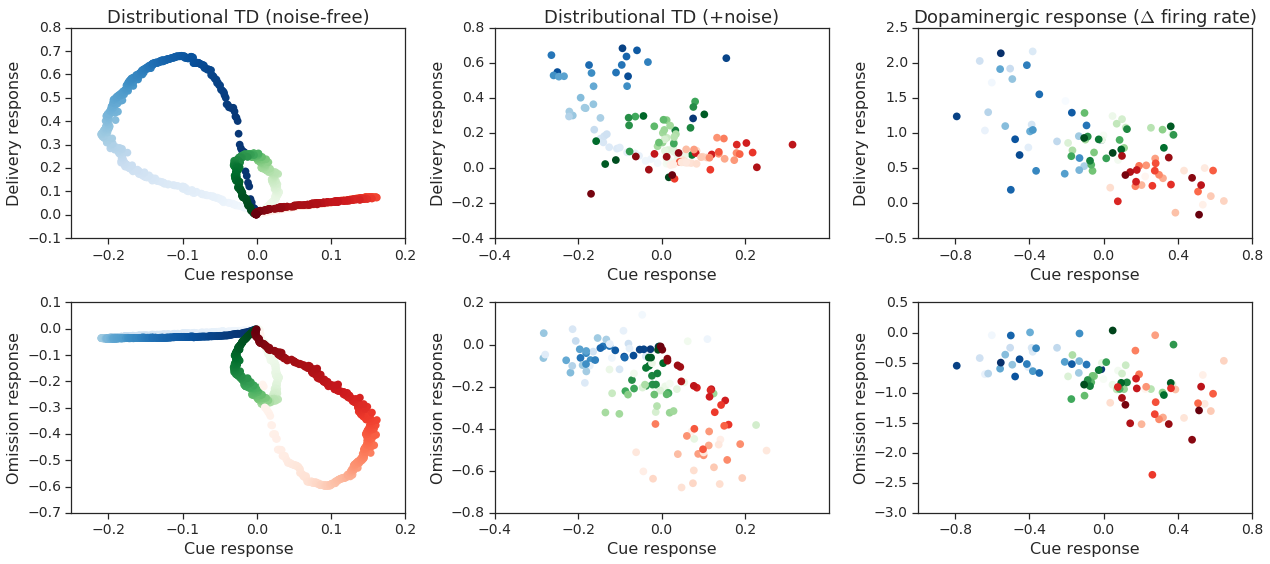

In [0]:
fig = plt.figure(figsize=(18, 8))

cols = [plt.cm.Blues, plt.cm.Greens, plt.cm.Reds]

psize=60
sigma = 0.1

plt.subplot(2, 3, 1)
plt.title("Distributional TD (noise-free)", fontsize=18)
for i in range(3):
  plt.scatter(responses[i],
              alpha_pos*(1 - (V_prime_sort[i])), 
              c=cols[i](tau), edgecolor='', s=psize)

plt.xlabel("Cue response", fontsize=16)
plt.ylabel("Delivery response", fontsize=16)
plt.xticks([-.2, -.1, 0., .1, .2])
plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best')

M = 42
ax = plt.subplot(2, 3, 2)
plt.title("Distributional TD (+noise)", fontsize=18)
ind = np.random.permutation(len(responses[0]))[:M]
for i in range(3):
  plt.scatter(responses[i][ind] + alpha_pos[ind]*np.random.normal(scale=sigma, size=M),
              alpha_pos[ind]*np.random.normal(scale=sigma, size=M) + alpha_pos[ind]*(1 - (V_prime_sort[i][ind])), 
              c=cols[i](tau[ind]), edgecolor='', zorder=5, s=psize)


plt.xlabel("Cue response", fontsize=16)
plt.ylabel("Delivery response", fontsize=16)
plt.tick_params(top=False, right=False, labelsize=14)


plt.subplot(2, 3, 4)
for i in range(3):
  plt.scatter(responses[i],
              alpha_neg*(0 - (V_prime_sort[i])),
              c=cols[i](tau), edgecolor='', s=psize)
plt.xlabel("Cue response", fontsize=16)
plt.ylabel("Omission response", fontsize=16)
plt.xticks([-.2, -.1, 0., .1, .2])
plt.tick_params(top=False, right=False, labelsize=14)

plt.subplot(2, 3, 5, sharex=ax)
for i in range(3):
  plt.scatter(responses[i][ind] + alpha_neg[ind]*np.random.normal(scale=sigma, size=M),
              alpha_neg[ind]*np.random.normal(scale=sigma, size=M) + alpha_neg[ind]*(0 - (V_prime_sort[i][ind])),
              c=cols[i](tau[ind]), edgecolor='', s=psize)

plt.xlabel("Cue response", fontsize=16)
plt.ylabel("Omission response", fontsize=16)
plt.xticks([-.4, -.2, 0., 0.2])
plt.ylim([-.8, .2])
plt.tick_params(top=False, right=False, labelsize=14)

plt.subplot(2, 3, 3)
plt.title("Dopaminergic response ($\Delta$ firing rate)", fontsize=18)
plt.scatter(avg_response[:, 0], avg_delivery[:, 0], c=plt.cm.Blues(np.linspace(0., 1., 31)), edgecolor='', s=psize)
plt.scatter(avg_response[:, 1], avg_delivery[:, 1], c=plt.cm.Greens(np.linspace(0., 1., 31)), edgecolor='', s=psize)
plt.scatter(avg_response[:, 2], avg_delivery[:, 2], c=plt.cm.Reds(np.linspace(0., 1., 31)), edgecolor='', s=psize)
plt.xlabel("Cue response", fontsize=16)
plt.ylabel("Delivery response", fontsize=16)
plt.xticks([-.8, -.4, 0., 0.4, 0.8])
plt.tick_params(top=False, right=False, labelsize=14)

plt.subplot(2, 3, 6)
plt.scatter(avg_response[:, 0], avg_omission[:, 0], c=plt.cm.Blues(np.linspace(0., 1., 31)), edgecolor='', s=psize)
plt.scatter(avg_response[:, 1], avg_omission[:, 1], c=plt.cm.Greens(np.linspace(0., 1., 31)), edgecolor='', s=psize)
plt.scatter(avg_response[:, 2], avg_omission[:, 2], c=plt.cm.Reds(np.linspace(0., 1., 31)), edgecolor='', s=psize)
plt.xlabel("Cue response", fontsize=16)
plt.ylabel("Omission response", fontsize=16)
plt.xticks([-.8, -.4, 0., 0.4, 0.8])
plt.tick_params(top=False, right=False, labelsize=14)

plt.tight_layout()

# CPW: Extended Data Figure 1 hij

In [0]:
def cpw(tau, eta):
  num = (tau)**eta
  return num / (num + (1. - tau)**eta)**(1./eta)

def value_power(x, alpha):
  return np.sign(x) * np.abs(x)**alpha

def cpt_value(outcomes, probabilities, alpha=0.88, beta=0.88, gamma=0.61, delta=0.69, lmbda=2.25):
  ind = np.argsort(outcomes)
  xs = outcomes[ind]
  ps = probabilities[ind]
  cps = np.array([0] + ps.tolist()).cumsum()
  
  posw = cpw(1. - cps, gamma)[:-1] - cpw(1. - cps, gamma)[1:]
  negw = cpw(cps, delta)[1:] - cpw(cps, delta)[:-1]

  value = 0.
  for i in range(len(xs)):
    if xs[i] > 0.:
      value += value_power(xs[i], alpha) * posw[i]
    else:
      value += value_power(xs[i], beta) * negw[i] * lmbda

  return value

def cpt_value_dual(outcomes, probabilities, alpha=0.88, beta=0.88, gamma=0.61, delta=0.69, lmbda=2.25):
  ind = np.argsort(outcomes)
  xs = outcomes[ind]
  ps = probabilities[ind]
  cps = np.array([0] + ps.tolist()).cumsum()
  params = np.array([delta] + [gamma if xs[i] > 0 else delta for i in range(len(xs))])
  values = np.array([value_power(xs[i], alpha) if xs[i] > 0 else lmbda*value_power(xs[i], beta) for i in range(len(xs))])
  values = np.hstack([values, [0.]])

  return np.dot(values[:-1] - values[1:], 1. - cpw(1. - cps, params)[1:])


def plot_cpt(values, taus, gamma=0.61, alpha=0.88):
  ind = np.argsort(taus)
  values = value_power(values[ind], alpha)
  taus = taus[ind]
  
  taus = np.array([0] + taus.tolist())
  weights = cpw(1. - taus, gamma)
  plt.plot(taus[1:], values, color='blue')

  expected_value = np.dot(weights[:-1] - weights[1:], values)
  plt.axhline(y=expected_value, linestyle='--')

  ax = plt.twinx()
  ax.plot(taus[1:], weights[:-1] - weights[1:], color='k')

  print(expected_value)

In [0]:
taus = np.linspace(0., 1., 102)[1:-1]
outcomes = np.array(sorted(np.random.normal(scale=.5, size=1000).tolist() + np.random.normal(loc=5., scale=.5, size=1000).tolist()))
outcomes -= outcomes.min()
quantiles = np.percentile(outcomes, taus*100.)

expectiles = np.zeros_like(taus)

for _ in range(20000):
  sample = np.random.choice(outcomes)
  delta = sample - expectiles
  weight = np.array(delta <= 0., dtype=np.float32)
  weight = np.abs(taus - weight)
  expectiles += 0.1 * weight * np.tanh(delta)



In [0]:
taus = np.linspace(0., 1., 102)[1:-1]

outcomes = np.random.normal(loc=0., scale=.0, size=2700).tolist() 
outcomes += np.random.normal(loc=1., scale=.0, size=7000).tolist()
outcomes += np.random.normal(loc=4., scale=.0, size=300).tolist()

outcomes = np.array(sorted(outcomes))
quantiles = np.percentile(outcomes, taus*100.)

expectiles = np.zeros_like(taus)

for _ in range(20000):
  sample = np.random.choice(outcomes)
  delta = sample - expectiles
  weight = np.array(delta <= 0., dtype=np.float32)
  weight = np.abs(taus - weight)
  expectiles += 0.1 * weight * np.tanh(delta)



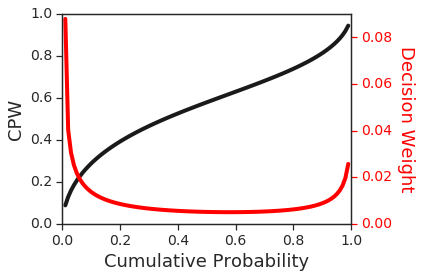

In [0]:
sns.set_style('white')
fig = plt.figure()
plt.plot(taus, 1. - cpw(1. - taus, 0.61), linewidth=4, color='k')
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()

plt.tick_params(labelsize=14)
plt.ylabel("CPW", fontsize=18)
plt.xlabel("Cumulative Probability", fontsize=18)

ax = plt.twinx()
t = np.hstack([[0.], taus])
weights = cpw(1. - t, 0.61)
ax.plot(taus, weights[:-1] - weights[1:], color='red', lw=4)
ax.set_yticks(np.arange(9)[::2]/100.)

plt.tick_params(labelsize=14)
plt.ylabel("Decision Weight", fontsize=18, rotation=270, va='bottom', color='red')
ax.tick_params('y', colors='red')

plt.tight_layout()


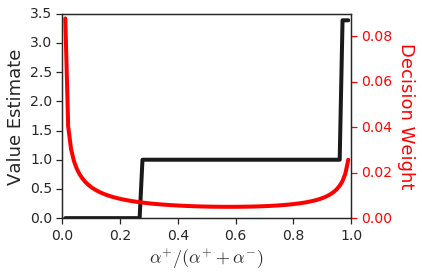

In [0]:
sns.set_style('white')
fig = plt.figure()
ind = np.argsort(taus)
values = value_power(quantiles[ind], 0.88)
t = taus[ind]
  
t = np.array([0] + t.tolist())
weights = cpw(1. - t, 0.61)

ax0 = plt.gca()
plt.plot(t[1:], values, color='k', linewidth=4, zorder=4)

expected_value = np.dot(weights[:-1] - weights[1:], values)
plt.ylim([0., 3.5])
plt.gca().yaxis.tick_left()
plt.gca().xaxis.tick_bottom()

plt.tick_params(labelsize=14)
plt.ylabel("Value Estimate", fontsize=18)
plt.xlabel("$\\alpha^{+}/(\\alpha^{+} + \\alpha^{-})$", fontsize=18)

ax = plt.twinx()
t = np.hstack([[0.], taus])
weights = cpw(1. - t, 0.61)
ax.plot(taus, weights[:-1] - weights[1:], color='red', lw=4, zorder=2)
ax.set_yticks(np.arange(9)[::2]/100.)

plt.tick_params(labelsize=14)
plt.ylabel("Decision Weight", fontsize=18, rotation=270, va='bottom', color='red')
ax.tick_params('y', colors='red')
plt.xlim([0., 1])

plt.tight_layout()
